# WebApp Covid19dynstat - using Dash/JupyterDash
@author: Jens Henrik Göbbert  
@mail: j.goebbert@fz-juelich.de

The `jupyter-dash` package makes it easy to develop Plotly Dash apps from the Jupyter Notebook and JupyterLab.
Just replace the standard `dash.Dash` class with the `jupyter_dash.JupyterDash` subclass.

### before publish
- set correct asset_url
- set cache_time=86400
- use app.run_server(mode="external")

In [1]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output, State
import dash_player
from flask_caching import Cache

import os
import pandas as pd

In [2]:
#print(dcc.__version__)

When running in JupyterHub (or Binder), call the `infer_jupyter_config` function to detect the proxy configuration. This will detect the proper request_pathname_prefix and server_url values to use when displaying Dash apps.  
For example:  
- server_url = `https://jupyter-jsc.fz-juelich.de`  
- request_pathname_prefix = `/user/j.goebbert@fz-juelich.de/jureca_login/`  

For details please check the source here https://github.com/plotly/jupyter-dash/blob/v0.2.1.post1/jupyter_dash/comms.py#L33

In [ ]:
from jupyter_dash import JupyterDash
JupyterDash.infer_jupyter_proxy_config()

**Attention:** I have to run this cell twice: first press play, wait a bit and hit play again while it still shows `[*]`

#### Create a Dash Flask server
Requests the browser to load Bootstrap 

In [31]:
from pathlib import Path

# create app
app = JupyterDash(__name__,
                  external_stylesheets=[dbc.themes.BOOTSTRAP],
                  update_title=None,
                  suppress_callback_exceptions=True, # because of multi-page setup
                 )

# config app
app.title = 'Covid-19-Interaktionsmodell'

cache_dir = "./cache"
Path(cache_dir).mkdir(parents=True, exist_ok=True)
cache = Cache(app.server, config={
    'CACHE_TYPE': 'filesystem',
    'CACHE_DIR': cache_dir,
    #'CACHE_THRESHOLD': 10000, # max. no. items stored before deletion starts (only for SimpleCache and FileSystemCache)
    ## try 'redis' if you want to use a database for caching
    #'CACHE_TYPE': 'redis'
    #'CACHE_REDIS_URL': os.environ.get('REDIS_URL', '')
})
cache_timeout=1 #86400  # on day in secounds

# clear cache to avoid any strange behaviour on restart while developing
cache.clear()
        
# start the server
server = app.server

In [32]:
from datetime import datetime as dt, timedelta

# set the base-url to the assets directory
asset_url="https://jupyter-jsc.fz-juelich.de" + os.environ['JUPYTERHUB_SERVICE_PREFIX'] + "proxy/8050/assets/"
#asset_url=app.get_asset_url('assets') + "/"
print(asset_url)

metadata = pd.read_csv("assets/metadata.csv")
#for index, row in metadata.iterrows():
#    print(row['countyId'])

deltadays = 25

min_date=dt(2020, 3, 26).date()
max_date=dt(2020, 3, 31).date() # dt.today().date()

init_date=dt(2020, 3, 26).date() # dt.today().date()
init_date=init_date -timedelta(days=deltadays)

init_assets_dir = init_date.strftime('%Y_%m_%d') + "/"
#print(init_assets_dir)

init_countyid=11001

def get_assets_dir(date):
    date = dt.strptime(date.split(' ')[0], '%Y-%m-%d')
    assets_dir = (date -timedelta(days=deltadays)).strftime('%Y_%m_%d') + "/"
    return assets_dir

https://jupyter-jsc.fz-juelich.de/user/a.grosch@fz-juelich.de/jureca_login/proxy/8050/assets/


#### Create interactive map of Germany

In [33]:
## load & initialize static data
# => tuple-list 'counties_geojson'
# => dataframe 'counties_metadf'
import json

# Landkreis-Geometrie vom RKI:
# https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/917fc37a709542548cc3be077a786c17_0 -> ShapeFile
# https://mapshaper.org -> GEOJSON

with open('assets/DE-Landkreise_RKI.geojson.json') as json_file:
    counties_geojson = json.load(json_file)

# 'id' must be the unique identifier of the shapes (required by plotly.Choroplethmapbox)
for i, feat in enumerate(counties_geojson['features']):
    feat['id'] = i

counties_metadf = pd.DataFrame(data={
        # geoid must match county-shape-ids in json file (must start with 0 and increase with no missing one)
        'geoids' :    [feat['id']                             for feat in counties_geojson['features']],
        'names'  :    [feat['properties'].get('GEN')          for feat in counties_geojson['features']],
        'cca'    :    [feat['properties'].get('RS')           for feat in counties_geojson['features']],
    })

# test 
#counties_metadf.loc[counties_metadf['cca']=='03159'] # data of Göttingen
#counties_metadf.to_csv('counties_metadata.csv', index=False)

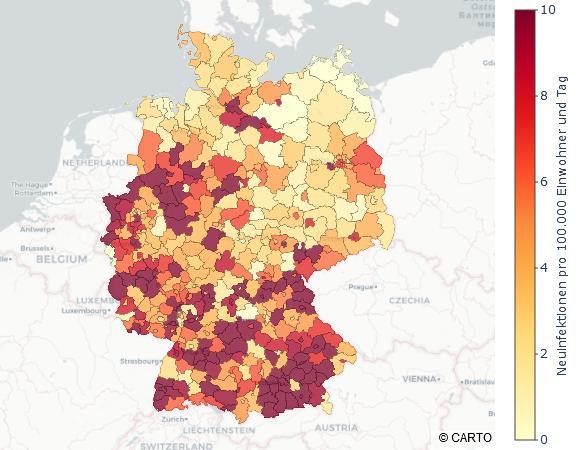

In [34]:
## load dynamic data
# => dataframe 'inf'
import plotly.graph_objects as go
from numpy import nan

def create_map(mapcsv_path, colName):

    infArr=[]
    try:
        # read number of infections from csv file        
        mapcsv = pd.read_csv(mapcsv_path)
        #print(mapcsv.loc[mapcsv['countyID'] == 3159]) # test with Göttingen

        # create (correctly sorted) dataframe from no.infections
        # loop over all counties and read no.infections from mapcsv 
        for feat in counties_geojson['features']: # same loop as for df (important)
            cca_str = feat['properties'].get('RS')
            if cca_str is not None:
                # read model value for this county from mapcsv
                cca_valuedf = mapcsv.loc[mapcsv['countyID']==int(cca_str), colName] #'newInf100k']
                cca_value = next(iter(cca_valuedf), 0.0)
                infArr.append(cca_value)             
            else:
                infArr.append(0.0)
    except: #IOError as e:
        print("File not found: " + mapcsv_path)
        for feat in counties_geojson['features']:
            infArr.append(nan)

    counties_infdf = pd.DataFrame(data={'infections': infArr})

    # test
    #print(inf['infections'][91]) # data of Freiburg
    #inf.to_csv('countyInfections_metadata.csv', index=False)

    # create figure
    mapfig = go.Figure(go.Choroplethmapbox(
                            geojson=counties_geojson,
                            locations=counties_metadf.geoids,
                            z=counties_infdf.infections,
                            text=counties_metadf.names,
                            colorscale="YlOrRd",
                            colorbar=dict(thickness=20, ticklen=3, title="Neuinfektionen pro 100.000 Einwohner und Tag", titleside="right"),
                            zmin=0, zmax=10,
                            marker_opacity=0.75, marker_line_width=0.1,
                            hovertemplate=
                                "<b>%{text}</b><br>" +
                                "%{z:.2f}<br>" +
                                "<extra></extra>",)
                      )
    mapfig.update_layout(
                        uirevision=True, # keep zoom,panning, etc. when updating
                        autosize=True,
                        #legend=dict(
                        #    # Adjust click behavior
                        #    itemclick="toggleothers",
                        #    itemdoubleclick="toggle",
                        #),
                        #xaxis=dict(
                        #    autorange='reversed',
                        #    fixedrange=True
                        #),
                        #yaxis=dict(
                        #    autorange='reversed',
                        #    fixedrange=True
                        #),
                        width=500, height=450,
                        mapbox_style="carto-positron", # https://plotly.com/python/mapbox-layers/
                        mapbox_zoom=4.5,
                        mapbox_center = {"lat": 51.30, "lon": 10.45},
                        margin={"r":0,"t":0,"l":0,"b":0})
    return mapfig

init_mapfig_bstim = create_map("assets/figures/" + init_assets_dir + "map.csv", 'newInf100k')
init_mapfig_rki   = create_map("assets/figures/" + init_assets_dir + "map.csv", 'newInf100k_RKI')
init_mapfig_bstim.show(config={"displayModeBar": False, "showTips": False, "modeBarButtonsToRemove": ['toImage']}) # "staticPlot": True})

#### Define the top navigation bar

In [35]:
#####################
# Disclaimer
#####################
disclaimer_modal = html.Div(
    [
        dcc.Markdown(
            f"""
            -----
            #####  BSTIM-Covid19 
            -----
            Aktuelle Daten und Vorhersage der täglich gemeldeten Neuinfektionen mit COVID-19 für Landkreise in Deutschland.
            Das Model beschreibt die zeitliche Entwicklung der Neuinfektionen in einen Zeitraum von mehreren Wochen.
            Es betrachtet dazu nicht nur die wahrscheinlichste Entwicklung oder die mittlere Entwicklung, sondern schätzt die Wahrscheinlichkeit für verschiedene Szenarien ab, die mit der aktuellen Datenlage kompatibel sind.
            Zudem wird die räumlich-zeitliche Komponente des Infektionsgeschehens geschätzt und als sogenannter "Interaktionskernel" dargestellt.
            Die Arbeit basiert auf einer Adaption des [BSTIM Models](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0225838#pone.0225838.ref009), angepasst an die COVID-19 Situation.
            Das Model beschreibt die tagesaktuellen Meldedaten basierend auf den [Daten](https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0/data?orderBy=Meldedatum) des RKI.
            
            Alle hier präsentierten Ergebnisse resultieren aus einer Modellierung basierend auf statistischen Methoden.
            Sie bilden damit nicht das reale Geschehen, sondern Schätzungen ab, die von der wirklichen Situation abweichen können.
            Dies ist bei der Interpretation der Ergebnisse zu berücksichtigen.
            Ebenso ist zu beachten, dass die Qualität dieser statistischen Methoden maßgeblich von der Qualität der zugrunde liegenden Daten abhängt.
            """
        ),
        html.Span(
            children=[
                dbc.Button("Disclaimer", id="disclaimer_modal_open", outline=True, color="secondary", className="mt-0"),
            ],
            style={
                "float": 'right',
                "marginTop": 0,
                "marginBottom": 10,
            },
        ),
        dbc.Modal(
            id="disclaimer_modal",
            size="xl",
            children=[
                dbc.ModalHeader("Disclaimer"),
                dbc.ModalBody(
                    children=[
                        dcc.Markdown(
                            f"""
                            Für die Gesamtzahl der Infektionen pro Bundesland/Landkreis werden die den Gesundheitsämtern nach Infektionsschutzgesetz gemeldeten Fälle verwendet,
                            die dem RKI bis zum jeweiligen Tag um 0 Uhr übermittelt wurden.
                            Für die Analyse wird das Meldedatum verwendet, s. [Details zu den Daten](https://experience.arcgis.com/experience/478220a4c454480e823b17327b2bf1d4)
                            Da es in dem Verfahren zu Differenzen zwischen Erkrankungsdatum und Meldedatum, sowie Verzögerungen in dem Meldeprozess geben kann,
                            ist die Analyse der Fallzahlen der letzten Woche bereits eine Vorhersage, die auf einer Schätzung basiert.
                            Alle hier präsentierten Ergebnisse basieren auf statistischen Methoden und bilden damit nicht das reale Geschehen, sondern Schätzungen ab, die von der wirklichen Situation abweichen können.
                            Dies ist bei der Interpretation der Ergebnisse zu berücksichtigen. 
                            Die hier präsentierten Forschungsergebnisse basieren auf einer neuen Methodik die bisher nicht für COVID-19 eingesetzt wurde. 
                            Die Validierung der Ergebnisse wird mit wachsender Menge an Daten in den kommenden Monaten fortgeführt. 
                            Für eine detailliertere Analyse der COVID-19-Fälle verweisen wir auf den [täglichen Lagebericht des RKI](https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Situationsberichte/Gesamt.html).
                            """
                        ),
                    ]
                ),
                dbc.ModalFooter(
                    dbc.Button("Schließen", id="disclaimer_modal_close", className="ml-auto")
                ),
            ],
        ),
    ]
)
@app.callback(
    Output("disclaimer_modal", "is_open"),
    [Input("disclaimer_modal_open", "n_clicks"), Input("disclaimer_modal_close", "n_clicks")],
    [State("disclaimer_modal", "is_open")],
)
def toggle_modal(n1, n2, is_open):
    if n1 or n2:
        return not is_open
    return is_open

In [36]:
#####################
# Impressum
#####################
impressum_modal = html.Div(
    [
        dbc.Button("Impressum", id="impressum_modal_open", outline=True, color="secondary", className="mr-1"),
        dbc.Modal(
            id="impressum_modal",
            size="xl",
            children=[
                dbc.ModalHeader("Impressum und Haftungsausschluss"),
                dbc.ModalBody(
                    children=[
                        dcc.Markdown(
                            f"""
                            ## Impressum
                            Das Projekt covid19dynstat ist ein gemeinsames Projekt des Institutes für Kognitionswissenschaft der Universität Osnabrück und des Jülich Supercomputing Centre am Forschungszentrum Jülich.

                            ### Inhaltlicher und wissenschaftlicher Kontakt
                            
                            Prof. Dr. Gordon Pipa

                            Institut für Kognitionswissenschaft  
                            Wachsbleiche 27  
                            49090 Osnabrück  
                            
                            Mailadresse: gpipa@uni-osnabrueck.de

                            ## Haftungsausschluss

                            ### Inhalt der eigenen Seiten
                            Wir haben die Internet-Seiten des Projektes covid19dynstat sorgfältig zusammengestellt.
                            Allerdings übernehmen wir keine Gewähr oder Haftung für die Aktualität, Vollständigkeit und Richtigkeit der angebotenen Informationen.

                            ### Links auf externe Web-Seiten
                            Die Internet-Seiten des Projektes covid19dynstat enthalten Links auf die Web-Seiten Dritter.
                            Diese Links auf die Web-Seiten Dritter stellen keine Zustimmung zu deren Inhalt dar.
                            Das Projekt covid19dynstat hat keinen Einfluss auf die aktuelle oder zukünftige Gestaltung dieser Seiten.
                            Wir übernehmen daher keine Haftung für die Verfügbarkeit oder den Inhalt solcher Web-Seiten und keine Haftung für Schäden, die aus der Nutzung solcher Inhalte entstehen.

                            ## Hoster
                            Die Webseiten des Projektes covid19dynstat werden gehostet am

                            Forschungszentrum Jülich GmbH  
                            Wilhelm-Johnen-Straße  
                            52428 Jülich  

                            #### Postanschrift:
                            52425 Jülich

                            #### Lieferanschrift:
                            Leo-Brandt-Straße  
                            52428 Jülich  

                            Eingetragen im Handelsregister des Amtsgerichts Düren Nr. HR B 3498  
                            Umsatzsteuer-Id-Nr. gem. § 27 a Umsatzsteuergesetz: DE 122624631  
                            Steuer-Nr.: 213/5700/0033  

                            #### Geschäftsführung:
                            - Prof. Dr.-Ing. Wolfgang Marquardt (Vorsitzender)  
                            - Karsten Beneke (Stellvertr. Vorsitzender)  
                            - Prof. Dr. Harald Bolt  

                            #### Vorsitzender des Aufsichtsrats:
                            Ministerialdirektor Volker Rieke

                            #### Kontakt:
                            Telefon-Sammel-Nr. 02461 61-0  
                            Telefax-Sammel-Nr. 02461 61-8100  

                            Internet: http://www.fz-juelich.de  
                            Mailadresse: info@fz-juelich.de  
                            """
                        ),
                    ]
                ),
                dbc.ModalFooter(
                   dbc.Button("Schließen", id="impressum_modal_close", className="ml-auto")
                ),
            ],
        ),
    ]
)
@app.callback(
    Output("impressum_modal", "is_open"),
    [Input("impressum_modal_open", "n_clicks"), Input("impressum_modal_close", "n_clicks")],
    [State("impressum_modal", "is_open")],
)
def toggle_modal(n1, n2, is_open):
    if n1 or n2:
        return not is_open
    return is_open

In [37]:
#####################
# Datenschutzerklärung
#####################
datenschutz_modal = html.Div(
    [
        dbc.Button("Datenschutz", id="datenschutz_modal_open", outline=True, color="secondary", className="mr-1"),
        dbc.Modal(
            id="datenschutz_modal",
            size="xl",
            children=[
                dbc.ModalHeader("Datenschutzerklärung"),
                dbc.ModalBody(
                    children=[
                        dcc.Markdown(
                            f"""
## Datenschutzerklärung

Wir freuen uns sehr über Ihr Interesse an unserem Projekt.
Datenschutz hat einen besonders hohen Stellenwert für das Projekt BSTIM-Covid19.
Eine Nutzung der Internetseiten des Projekts BSTIM-Covid19 ist grundsätzlich ohne jede Angabe personenbezogener Daten möglich.
Sofern eine betroffene Person besondere Services unseres Projekts über unsere Internetseite in Anspruch nehmen möchte, könnte jedoch eine Verarbeitung personenbezogener Daten erforderlich werden.
Ist die Verarbeitung personenbezogener Daten erforderlich und besteht für eine solche Verarbeitung keine gesetzliche Grundlage, holen wir generell eine Einwilligung der betroffenen Person ein.

Die Verarbeitung personenbezogener Daten, beispielsweise des Namens, der Anschrift, E-Mail-Adresse oder Telefonnummer einer betroffenen Person, erfolgt stets im Einklang mit der Datenschutz-Grundverordnung und in Übereinstimmung mit den für das Projekt BSTIM-Covid19 geltenden landesspezifischen Datenschutzbestimmungen.
Mittels dieser Datenschutzerklärung möchte unser Projekt die Öffentlichkeit über Art, Umfang und Zweck der von uns erhobenen, genutzten und verarbeiteten personenbezogenen Daten informieren.
Ferner werden betroffene Personen mittels dieser Datenschutzerklärung über die ihnen zustehenden Rechte aufgeklärt.

Das Projekt BSTIM-Covid19 hat als für die Verarbeitung Verantwortlicher zahlreiche technische und organisatorische Maßnahmen umgesetzt, um einen möglichst lückenlosen Schutz der über diese Internetseite verarbeiteten personenbezogenen Daten sicherzustellen.
Dennoch können Internetbasierte Datenübertragungen grundsätzlich Sicherheitslücken aufweisen, sodass ein absoluter Schutz nicht gewährleistet werden kann. Aus diesem Grund steht es jeder betroffenen Person frei, personenbezogene Daten auch auf alternativen Wegen, beispielsweise telefonisch, an uns zu übermitteln.

### 1. Begriffsbestimmungen
Die Datenschutzerklärung des Projekts BSTIM-Covid19 beruht auf den Begrifflichkeiten, die durch den Europäischen Richtlinien- und Verordnungsgeber beim Erlass der Datenschutz-Grundverordnung (DSGVO) verwendet wurden.
Unsere Datenschutzerklärung soll sowohl für die Öffentlichkeit als auch für unsere Kunden und Geschäftspartner einfach lesbar und verständlich sein. Um dies zu gewährleisten, möchten wir vorab die verwendeten Begrifflichkeiten erläutern.

Wir verwenden in dieser Datenschutzerklärung unter anderem die folgenden Begriffe:
#### a) personenbezogene Daten
Personenbezogene Daten sind alle Informationen, die sich auf eine identifizierte oder identifizierbare natürliche Person (im Folgenden „betroffene Person“) beziehen.
Als identifizierbar wird eine natürliche Person angesehen, die direkt oder indirekt, insbesondere mittels Zuordnung zu einer Kennung wie einem Namen, zu einer Kennnummer, zu Standortdaten, zu einer Online-Kennung oder zu einem oder mehreren besonderen Merkmalen, die Ausdruck der physischen, physiologischen, genetischen, psychischen, wirtschaftlichen, kulturellen oder sozialen Identität dieser natürlichen Person sind, identifiziert werden kann.
#### b) betroffene Person
Betroffene Person ist jede identifizierte oder identifizierbare natürliche Person, deren personenbezogene Daten von dem für die Verarbeitung Verantwortlichen verarbeitet werden.
#### c) Verarbeitung
Verarbeitung ist jeder mit oder ohne Hilfe automatisierter Verfahren ausgeführte Vorgang oder jede solche Vorgangsreihe im Zusammenhang mit personenbezogenen Daten wie das Erheben, das Erfassen, die Organisation, das Ordnen, die Speicherung, die Anpassung oder Veränderung, das Auslesen, das Abfragen, die Verwendung, die Offenlegung durch Übermittlung, Verbreitung oder eine andere Form der Bereitstellung, den Abgleich oder die Verknüpfung, die Einschränkung, das Löschen oder die Vernichtung.
#### d) Einschränkung der Verarbeitung
Einschränkung der Verarbeitung ist die Markierung gespeicherter personenbezogener Daten mit dem Ziel, ihre künftige Verarbeitung einzuschränken.
#### e) Profiling
Profiling ist jede Art der automatisierten Verarbeitung personenbezogener Daten, die darin besteht, dass diese personenbezogenen Daten verwendet werden, um bestimmte persönliche Aspekte, die sich auf eine natürliche Person beziehen, zu bewerten, insbesondere, um Aspekte bezüglich Arbeitsleistung, wirtschaftlicher Lage, Gesundheit, persönlicher Vorlieben, Interessen, Zuverlässigkeit, Verhalten, Aufenthaltsort oder Ortswechsel dieser natürlichen Person zu analysieren oder vorherzusagen.
#### f) Pseudonymisierung
Pseudonymisierung ist die Verarbeitung personenbezogener Daten in einer Weise, auf welche die personenbezogenen Daten ohne Hinzuziehung zusätzlicher Informationen nicht mehr einer spezifischen betroffenen Person zugeordnet werden können, sofern diese zusätzlichen Informationen gesondert aufbewahrt werden und technischen und organisatorischen Maßnahmen unterliegen, die gewährleisten, dass die personenbezogenen Daten nicht einer identifizierten oder identifizierbaren natürlichen Person zugewiesen werden.
#### g) Verantwortlicher oder für die Verarbeitung Verantwortlicher
Verantwortlicher oder für die Verarbeitung Verantwortlicher ist die natürliche oder juristische Person, Behörde, Einrichtung oder andere Stelle, die allein oder gemeinsam mit anderen über die Zwecke und Mittel der Verarbeitung von personenbezogenen Daten entscheidet.
Sind die Zwecke und Mittel dieser Verarbeitung durch das Unionsrecht oder das Recht der Mitgliedstaaten vorgegeben, so kann der Verantwortliche beziehungsweise können die bestimmten Kriterien seiner Benennung nach dem Unionsrecht oder dem Recht der Mitgliedstaaten vorgesehen werden.
#### h) Auftragsverarbeiter
Auftragsverarbeiter ist eine natürliche oder juristische Person, Behörde, Einrichtung oder andere Stelle, die personenbezogene Daten im Auftrag des Verantwortlichen verarbeitet.
#### i) Empfänger
Empfänger ist eine natürliche oder juristische Person, Behörde, Einrichtung oder andere Stelle, der personenbezogene Daten offengelegt werden, unabhängig davon, ob es sich bei ihr um einen Dritten handelt oder nicht.
Behörden, die im Rahmen eines bestimmten Untersuchungsauftrags nach dem Unionsrecht oder dem Recht der Mitgliedstaaten möglicherweise personenbezogene Daten erhalten, gelten jedoch nicht als Empfänger.
#### j) Dritter
Dritter ist eine natürliche oder juristische Person, Behörde, Einrichtung oder andere Stelle außer der betroffenen Person, dem Verantwortlichen, dem Auftragsverarbeiter und den Personen, die unter der unmittelbaren Verantwortung des Verantwortlichen oder des Auftragsverarbeiters befugt sind, die personenbezogenen Daten zu verarbeiten.
#### k) Einwilligung
Einwilligung ist jede von der betroffenen Person freiwillig für den bestimmten Fall in informierter Weise und unmissverständlich abgegebene Willensbekundung in Form einer Erklärung oder einer sonstigen eindeutigen bestätigenden Handlung, mit der die betroffene Person zu verstehen gibt, dass sie mit der Verarbeitung der sie betreffenden personenbezogenen Daten einverstanden ist.

### 2. Name und Anschrift des für die Verarbeitung Verantwortlichen 
Verantwortlicher im Sinne der Datenschutz-Grundverordnung, sonstiger in den Mitgliedstaaten der Europäischen Union geltenden Datenschutzgesetze und anderer Bestimmungen mit datenschutzrechtlichem Charakter ist:

Projekt BSTIM-Covid19  
Prof. Dr. Gordon Pipa

Institut für Kognitionswissenschaft  
Wachsbleiche 27  
49090 Osnabrück  

Mailadresse: gpipa@uni-osnabrueck.de

#### a) Hoster
Die Webseiten des Projekts BSTIM-Covid19 werden gehostet von der

Forschungszentrum Jülich GmbH  
Wilhelm-Johnen-Straße  
52428 Jülich  
Germany

### 3. Name und Anschrift des Datenschutzbeauftragten
Der Datenschutzbeauftragte des für die Verarbeitung Verantwortlichen ist:

Frank Rinkens  
Forschungszentrum Jülich GmbH  
Wilhelm-Johnen-Strasse  
52428 Jülich  

Deutschland

Tel.: +49 2461 61-9005

Website: [www.fz-juelich.de](https://www.fz-juelich.de)  
E-Mail: DSB@fz-juelich.de  

Jede betroffene Person kann sich jederzeit bei allen Fragen und Anregungen zum Datenschutz direkt an unseren Datenschutzbeauftragten wenden.

### 4. Cookies
Die Internetseiten des Projekts BSTIM-Covid19 verwenden Cookies.
Cookies sind Textdateien, welche über einen Internetbrowser auf einem Computersystem abgelegt und gespeichert werden.

Zahlreiche Internetseiten und Server verwenden Cookies. Viele Cookies enthalten eine sogenannte Cookie-ID. Eine Cookie-ID ist eine eindeutige Kennung des Cookies.
Sie besteht aus einer Zeichenfolge, durch welche Internetseiten und Server dem konkreten Internetbrowser zugeordnet werden können, in dem das Cookie gespeichert wurde.
Dies ermöglicht es den besuchten Internetseiten und Servern, den individuellen Browser der betroffenen Person von anderen Internetbrowsern, die andere Cookies enthalten, zu unterscheiden.
Ein bestimmter Internetbrowser kann über die eindeutige Cookie-ID wiedererkannt und identifiziert werden.

Durch den Einsatz von Cookies kann das Projekt BSTIM-Covid19 den Nutzern dieser Internetseite nutzerfreundlichere Services bereitstellen, die ohne die Cookie-Setzung nicht möglich wären.

Mittels eines Cookies können die Informationen und Angebote auf unserer Internetseite im Sinne des Benutzers optimiert werden. Cookies ermöglichen uns, wie bereits erwähnt, die Benutzer unserer Internetseite wiederzuerkennen.
Zweck dieser Wiedererkennung ist es, den Nutzern die Verwendung unserer Internetseite zu erleichtern.
Der Benutzer einer Internetseite, die Cookies verwendet, muss beispielsweise nicht bei jedem Besuch der Internetseite erneut seine Zugangsdaten eingeben, weil dies von der Internetseite und dem auf dem Computersystem des Benutzers abgelegten Cookie übernommen wird.
Ein weiteres Beispiel ist das Cookie eines Warenkorbes im Online-Shop. Der Online-Shop merkt sich die Artikel, die ein Kunde in den virtuellen Warenkorb gelegt hat, über ein Cookie.

Die betroffene Person kann die Setzung von Cookies durch unsere Internetseite jederzeit mittels einer entsprechenden Einstellung des genutzten Internetbrowsers verhindern und damit der Setzung von Cookies dauerhaft widersprechen.
Ferner können bereits gesetzte Cookies jederzeit über einen Internetbrowser oder andere Softwareprogramme gelöscht werden.
Dies ist in allen gängigen Internetbrowsern möglich. Deaktiviert die betroffene Person die Setzung von Cookies in dem genutzten Internetbrowser, sind unter Umständen nicht alle Funktionen unserer Internetseite vollumfänglich nutzbar.

### 5. Erfassung von allgemeinen Daten und Informationen
Die Internetseite des Projekts BSTIM-Covid19 erfasst mit jedem Aufruf der Internetseite durch eine betroffene Person oder ein automatisiertes System eine Reihe von allgemeinen Daten und Informationen.
Diese allgemeinen Daten und Informationen werden in den Logfiles des Servers gespeichert.
Erfasst werden können die 
(1) verwendeten Browsertypen und Versionen, 
(2) das vom zugreifenden System verwendete Betriebssystem, 
(3) die Internetseite, von welcher ein zugreifendes System auf unsere Internetseite gelangt (sogenannte Referrer), 
(4) die Unterwebseiten, welche über ein zugreifendes System auf unserer Internetseite angesteuert werden, 
(5) das Datum und die Uhrzeit eines Zugriffs auf die Internetseite, 
(6) eine Internet-Protokoll-Adresse (IP-Adresse), 
(7) der Internet-Service-Provider des zugreifenden Systems und 
(8) sonstige ähnliche Daten und Informationen, die der Gefahrenabwehr im Falle von Angriffen auf unsere informationstechnologischen Systeme dienen.

Bei der Nutzung dieser allgemeinen Daten und Informationen zieht das Projekt BSTIM-Covid19 keine Rückschlüsse auf die betroffene Person.
Diese Informationen werden vielmehr benötigt, um
(1) die Inhalte unserer Internetseite korrekt auszuliefern,
(2) die dauerhafte Funktionsfähigkeit unserer informationstechnologischen Systeme und der Technik unserer Internetseite zu gewährleisten sowie
(3) um Strafverfolgungsbehörden im Falle eines Cyberangriffes die zur Strafverfolgung notwendigen Informationen bereitzustellen.
Diese anonym erhobenen Daten und Informationen werden durch das Projekt BSTIM-Covid19 daher einerseits statistisch und ferner mit dem Ziel ausgewertet, den Datenschutz und die Datensicherheit in unserem Projekt zu erhöhen, um letztlich ein optimales Schutzniveau für die von uns verarbeiteten personenbezogenen Daten sicherzustellen.
Die anonymen Daten der Server-Logfiles werden getrennt von allen durch eine betroffene Person angegebenen personenbezogenen Daten gespeichert.

### 6. Kontaktmöglichkeit über die Internetseite
Die Internetseite des Projekts BSTIM-Covid19 enthält aufgrund von gesetzlichen Vorschriften Angaben, die eine schnelle elektronische Kontaktaufnahme zu unserem Projekt sowie eine unmittelbare Kommunikation mit uns ermöglichen, was ebenfalls eine allgemeine Adresse der sogenannten elektronischen Post (E-Mail-Adresse) umfasst.
Sofern eine betroffene Person per E-Mail oder über ein Kontaktformular den Kontakt mit dem für die Verarbeitung Verantwortlichen aufnimmt, werden die von der betroffenen Person übermittelten personenbezogenen Daten automatisch gespeichert.
Solche auf freiwilliger Basis von einer betroffenen Person an den für die Verarbeitung Verantwortlichen übermittelten personenbezogenen Daten werden für Zwecke der Bearbeitung oder der Kontaktaufnahme zur betroffenen Person gespeichert.
Es erfolgt keine Weitergabe dieser personenbezogenen Daten an Dritte.

### 7. Routinemäßige Löschung und Sperrung von personenbezogenen Daten
Der für die Verarbeitung Verantwortliche verarbeitet und speichert personenbezogene Daten der betroffenen Person nur für den Zeitraum, der zur Erreichung des Speicherungszwecks erforderlich ist oder sofern dies durch den Europäischen Richtlinien- und Verordnungsgeber oder einen anderen Gesetzgeber in Gesetzen oder Vorschriften, welchen der für die Verarbeitung Verantwortliche unterliegt, vorgesehen wurde.

Entfällt der Speicherungszweck oder läuft eine vom Europäischen Richtlinien- und Verordnungsgeber oder einem anderen zuständigen Gesetzgeber vorgeschriebene Speicherfrist ab, werden die personenbezogenen Daten routinemäßig und entsprechend den gesetzlichen Vorschriften gesperrt oder gelöscht.

### 8. Rechte der betroffenen Person
#### a) Recht auf Bestätigung
Jede betroffene Person hat das vom Europäischen Richtlinien- und Verordnungsgeber eingeräumte Recht, von dem für die Verarbeitung Verantwortlichen eine Bestätigung darüber zu verlangen, ob sie betreffende personenbezogene Daten verarbeitet werden.
Möchte eine betroffene Person dieses Bestätigungsrecht in Anspruch nehmen, kann sie sich hierzu jederzeit an den für die Verarbeitung Verantwortlichen wenden.

#### b) Recht auf Auskunft
Jede von der Verarbeitung personenbezogener Daten betroffene Person hat das vom Europäischen Richtlinien- und Verordnungsgeber gewährte Recht, jederzeit von dem für die Verarbeitung Verantwortlichen unentgeltliche Auskunft über die zu seiner Person gespeicherten personenbezogenen Daten und eine Kopie dieser Auskunft zu erhalten.
Ferner hat der Europäische Richtlinien- und Verordnungsgeber der betroffenen Person Auskunft über folgende Informationen zugestanden:
   - die Verarbeitungszwecke
   - die Kategorien personenbezogener Daten, die verarbeitet werden
   - die Empfänger oder Kategorien von Empfängern, gegenüber denen die personenbezogenen Daten offengelegt worden sind oder noch offengelegt werden, insbesondere bei Empfängern in Drittländern oder bei internationalen Organisationen
   - falls möglich die geplante Dauer, für die die personenbezogenen Daten gespeichert werden, oder, falls dies nicht möglich ist, die Kriterien für die Festlegung dieser Dauer
   - das Bestehen eines Rechts auf Berichtigung oder Löschung der sie betreffenden personenbezogenen Daten oder auf Einschränkung der Verarbeitung durch den Verantwortlichen oder eines Widerspruchsrechts gegen diese Verarbeitung
   - das Bestehen eines Beschwerderechts bei einer Aufsichtsbehörde
   - wenn die personenbezogenen Daten nicht bei der betroffenen Person erhoben werden: Alle verfügbaren Informationen über die Herkunft der Daten
   - das Bestehen einer automatisierten Entscheidungsfindung einschließlich Profiling gemäß Artikel 22 Abs.1 und 4 DSGVO und — zumindest in diesen Fällen — aussagekräftige Informationen über die involvierte Logik sowie die Tragweite und die angestrebten Auswirkungen einer derartigen Verarbeitung für die betroffene Person

Ferner steht der betroffenen Person ein Auskunftsrecht darüber zu, ob personenbezogene Daten an ein Drittland oder an eine internationale Organisation übermittelt wurden.
Sofern dies der Fall ist, so steht der betroffenen Person im Übrigen das Recht zu, Auskunft über die geeigneten Garantien im Zusammenhang mit der Übermittlung zu erhalten.

Möchte eine betroffene Person dieses Auskunftsrecht in Anspruch nehmen, kann sie sich hierzu jederzeit an den für die Verarbeitung Verantwortlichen wenden.

#### c) Recht auf Berichtigung
Jede von der Verarbeitung personenbezogener Daten betroffene Person hat das, vom Europäischen Richtlinien- und Verordnungsgeber gewährte Recht, die unverzügliche Berichtigung sie betreffender unrichtiger personenbezogener Daten zu verlangen.
Ferner steht der betroffenen Person das Recht zu, unter Berücksichtigung der Zwecke der Verarbeitung, die Vervollständigung unvollständiger personenbezogener Daten — auch mittels einer ergänzenden Erklärung — zu verlangen.

Möchte eine betroffene Person dieses Berichtigungsrecht in Anspruch nehmen, kann sie sich hierzu jederzeit an den für die Verarbeitung Verantwortlichen wenden.

#### d) Recht auf Löschung (Recht auf Vergessen werden)
Jede von der Verarbeitung personenbezogener Daten betroffene Person hat das vom Europäischen Richtlinien- und Verordnungsgeber gewährte Recht, von dem Verantwortlichen zu verlangen, dass die sie betreffenden personenbezogenen Daten unverzüglich gelöscht werden, sofern einer der folgenden Gründe zutrifft und soweit die Verarbeitung nicht erforderlich ist:
   - Die personenbezogenen Daten wurden für solche Zwecke erhoben oder auf sonstige Weise verarbeitet, für welche sie nicht mehr notwendig sind.
   - Die betroffene Person widerruft ihre Einwilligung, auf die sich die Verarbeitung gemäß Art. 6 Abs. 1 Buchstabe a DSGVO oder Art. 9 Abs. 2 Buchstabe a DSGVO stützte, und es fehlt an einer anderweitigen Rechtsgrundlage für die Verarbeitung.
   - Die betroffene Person legt gemäß Art. 21 Abs. 1 DSGVO Widerspruch gegen die Verarbeitung ein, und es liegen keine vorrangigen berechtigten Gründe für die Verarbeitung vor, oder die betroffene Person legt gemäß Art. 21 Abs. 2 DSGVO Widerspruch gegen die Verarbeitung ein.
   - Die personenbezogenen Daten wurden unrechtmäßig verarbeitet.
   - Die Löschung der personenbezogenen Daten ist zur Erfüllung einer rechtlichen Verpflichtung nach dem Unionsrecht oder dem Recht der Mitgliedstaaten erforderlich, dem der Verantwortliche unterliegt.
   - Die personenbezogenen Daten wurden in Bezug auf angebotene Dienste der Informationsgesellschaft gemäß Art. 8 Abs. 1 DSGVO erhoben.

Sofern einer der oben genannten Gründe zutrifft und eine betroffene Person die Löschung von personenbezogenen Daten, die beim Projekt BSTIM-Covid19 gespeichert sind, veranlassen möchte, kann sie sich hierzu jederzeit an den für die Verarbeitung Verantwortlichen wenden.
Ein Mitarbeiter des Projekts BSTIM-Covid19 wird veranlassen, dass dem Löschverlangen unverzüglich nachgekommen wird.

Wurden die personenbezogenen Daten vom Projekt BSTIM-Covid19 öffentlich gemacht und ist unser Projekt als Verantwortlicher gemäß Art. 17 Abs. 1 DSGVO zur Löschung der personenbezogenen Daten verpflichtet, so trifft das Projekt BSTIM-Covid19 unter Berücksichtigung der verfügbaren Technologie und der Implementierungskosten angemessene Maßnahmen, auch technischer Art, um andere für die Datenverarbeitung Verantwortliche, welche die veröffentlichten personenbezogenen Daten verarbeiten, darüber in Kenntnis zu setzen, dass die betroffene Person von diesen anderen für die Datenverarbeitung Verantwortlichen die Löschung sämtlicher Links zu diesen personenbezogenen Daten oder von Kopien oder Replikationen dieser personenbezogenen Daten verlangt hat, soweit die Verarbeitung nicht erforderlich ist. Ein Mitarbeiter des Projekts BSTIM-Covid19 wird im Einzelfall das Notwendige veranlassen.

#### e) Recht auf Einschränkung der Verarbeitung
Jede von der Verarbeitung personenbezogener Daten betroffene Person hat das vom Europäischen Richtlinien- und Verordnungsgeber gewährte Recht, von dem Verantwortlichen die Einschränkung der Verarbeitung zu verlangen, wenn eine der folgenden Voraussetzungen gegeben ist:
   - Die Richtigkeit der personenbezogenen Daten wird von der betroffenen Person bestritten, und zwar für eine Dauer, die es dem Verantwortlichen ermöglicht, die Richtigkeit der personenbezogenen Daten zu überprüfen.
   - Die Verarbeitung ist unrechtmäßig, die betroffene Person lehnt die Löschung der personenbezogenen Daten ab und verlangt stattdessen die Einschränkung der Nutzung der personenbezogenen Daten.
   - Der Verantwortliche benötigt die personenbezogenen Daten für die Zwecke der Verarbeitung nicht länger, die betroffene Person benötigt sie jedoch zur Geltendmachung, Ausübung oder Verteidigung von Rechtsansprüchen.
   - Die betroffene Person hat Widerspruch gegen die Verarbeitung gem. Art. 21 Abs. 1 DSGVO eingelegt und es steht noch nicht fest, ob die berechtigten Gründe des Verantwortlichen gegenüber denen der betroffenen Person überwiegen.

Sofern eine der oben genannten Voraussetzungen gegeben ist und eine betroffene Person die Einschränkung von personenbezogenen Daten, die beim Projekt BSTIM-Covid19 gespeichert sind, verlangen möchte, kann sie sich hierzu jederzeit an den für die Verarbeitung Verantwortlichen wenden. Ein Mitarbeiter des Projekts BSTIM-Covid19 wird die Einschränkung der Verarbeitung veranlassen.

#### f) Recht auf Datenübertragbarkeit
Jede von der Verarbeitung personenbezogener Daten betroffene Person hat das vom Europäischen Richtlinien- und Verordnungsgeber gewährte Recht, die sie betreffenden personenbezogenen Daten, welche durch die betroffene Person einem Verantwortlichen bereitgestellt wurden, in einem strukturierten, gängigen und maschinenlesbaren Format zu erhalten. Sie hat außerdem das Recht, diese Daten einem anderen Verantwortlichen ohne Behinderung durch den Verantwortlichen, dem die personenbezogenen Daten bereitgestellt wurden, zu übermitteln, sofern die Verarbeitung auf der Einwilligung gemäß Art. 6 Abs. 1 Buchstabe a DSGVO oder Art. 9 Abs. 2 Buchstabe a DSGVO oder auf einem Vertrag gemäß Art. 6 Abs. 1 Buchstabe b DSGVO beruht und die Verarbeitung mithilfe automatisierter Verfahren erfolgt, sofern die Verarbeitung nicht für die Wahrnehmung einer Aufgabe erforderlich ist, die im öffentlichen Interesse liegt oder in Ausübung öffentlicher Gewalt erfolgt, welche dem Verantwortlichen übertragen wurde.

Ferner hat die betroffene Person bei der Ausübung ihres Rechts auf Datenübertragbarkeit gemäß Art. 20 Abs. 1 DSGVO das Recht, zu erwirken, dass die personenbezogenen Daten direkt von einem Verantwortlichen an einen anderen Verantwortlichen übermittelt werden, soweit dies technisch machbar ist und sofern hiervon nicht die Rechte und Freiheiten anderer Personen beeinträchtigt werden.  
Zur Geltendmachung des Rechts auf Datenübertragbarkeit kann sich die betroffene Person jederzeit an den für die Verarbeitung Verantwortlichen des Projekts BSTIM-Covid19 wenden.

#### g) Recht auf Widerspruch
Jede von der Verarbeitung personenbezogener Daten betroffene Person hat das vom Europäischen Richtlinien- und Verordnungsgeber gewährte Recht, aus Gründen, die sich aus ihrer besonderen Situation ergeben, jederzeit gegen die Verarbeitung sie betreffender personenbezogener Daten, die aufgrund von Art. 6 Abs. 1 Buchstaben e oder f DSGVO erfolgt, Widerspruch einzulegen. Dies gilt auch für ein auf diese Bestimmungen gestütztes Profiling.

Das Projekt BSTIM-Covid19 verarbeitet die personenbezogenen Daten im Falle des Widerspruchs nicht mehr, es sei denn, wir können zwingende schutzwürdige Gründe für die Verarbeitung nachweisen, die den Interessen, Rechten und Freiheiten der betroffenen Person überwiegen, oder die Verarbeitung dient der Geltendmachung, Ausübung oder Verteidigung von Rechtsansprüchen.

Zudem hat die betroffene Person das Recht, aus Gründen, die sich aus ihrer besonderen Situation ergeben, gegen die sie betreffende Verarbeitung personenbezogener Daten, die beim Projekt BSTIM-Covid19 zu wissenschaftlichen oder historischen Forschungszwecken oder zu statistischen Zwecken gemäß Art. 89 Abs. 1 DSGVO erfolgen, Widerspruch einzulegen, es sei denn, eine solche Verarbeitung ist zur Erfüllung einer im öffentlichen Interesse liegenden Aufgabe erforderlich.

Zur Ausübung des Rechts auf Widerspruch kann sich die betroffene Person direkt an den für die Verarbeitung Verantwortlichen des Projekts BSTIM-Covid19 wenden.
Der betroffenen Person steht es ferner frei, im Zusammenhang mit der Nutzung von Diensten der Informationsgesellschaft, ungeachtet der Richtlinie 2002/58/EG, ihr Widerspruchsrecht mittels automatisierter Verfahren auszuüben, bei denen technische Spezifikationen verwendet werden.

#### h) Automatisierte Entscheidungen im Einzelfall einschließlich Profiling
Jede von der Verarbeitung personenbezogener Daten betroffene Person hat das vom Europäischen Richtlinien- und Verordnungsgeber gewährte Recht, nicht einer ausschließlich auf einer automatisierten Verarbeitung — einschließlich Profiling — beruhenden Entscheidung unterworfen zu werden, die ihr gegenüber rechtliche Wirkung entfaltet oder sie in ähnlicher Weise erheblich beeinträchtigt, sofern die Entscheidung 
(1) nicht für den Abschluss oder die Erfüllung eines Vertrags zwischen der betroffenen Person und dem Verantwortlichen erforderlich ist, oder 
(2) aufgrund von Rechtsvorschriften der Union oder der Mitgliedstaaten, denen der Verantwortliche unterliegt, zulässig ist und diese Rechtsvorschriften angemessene Maßnahmen zur Wahrung der Rechte und Freiheiten sowie der berechtigten Interessen der betroffenen Person enthalten oder 
(3) mit ausdrücklicher Einwilligung der betroffenen Person erfolgt.

Ist die Entscheidung 
(1) für den Abschluss oder die Erfüllung eines Vertrags zwischen der betroffenen Person und dem Verantwortlichen erforderlich oder 
(2) erfolgt sie mit ausdrücklicher Einwilligung der betroffenen Person, trifft das Projekt BSTIM-Covid19 angemessene Maßnahmen, um die Rechte und Freiheiten sowie die berechtigten Interessen der betroffenen Person zu wahren, wozu mindestens das Recht auf Erwirkung des Eingreifens einer Person seitens des Verantwortlichen, auf Darlegung des eigenen Standpunkts und auf Anfechtung der Entscheidung gehört.

Möchte die betroffene Person Rechte mit Bezug auf automatisierte Entscheidungen geltend machen, kann sie sich hierzu jederzeit an den für die Verarbeitung Verantwortlichen wenden.

#### i) Recht auf Widerruf einer datenschutzrechtlichen Einwilligung
Jede von der Verarbeitung personenbezogener Daten betroffene Person hat das vom Europäischen Richtlinien- und Verordnungsgeber gewährte Recht, eine Einwilligung zur Verarbeitung personenbezogener Daten jederzeit zu widerrufen.

Möchte die betroffene Person ihr Recht auf Widerruf einer Einwilligung geltend machen, kann sie sich hierzu jederzeit an den für die Verarbeitung Verantwortlichen wenden.

Unbeschadet eines anderweitigen verwaltungsrechtlichen oder gerichtlichen Rechtsbehelfs steht Ihnen das Recht auf Beschwerde bei einer Aufsichtsbehörde, insbesondere in dem Mitgliedstaat ihres Aufenthaltsorts, ihres Arbeitsplatzes oder des Orts des mutmaßlichen Verstoßes, zu, wenn Sie der Ansicht sind, dass die Verarbeitung der Sie betreffenden personenbezogenen Daten gegen die DSGVO verstößt.

### 9. Rechtsgrundlage der Verarbeitung
Art. 6 I lit. a DSGVO dient unserem Projekt als Rechtsgrundlage für Verarbeitungsvorgänge, bei denen wir eine Einwilligung für einen bestimmten Verarbeitungszweck einholen.
Ist die Verarbeitung personenbezogener Daten zur Erfüllung eines Vertrags, dessen Vertragspartei die betroffene Person ist, erforderlich, wie dies beispielsweise bei Verarbeitungsvorgängen der Fall ist, die für eine Lieferung von Waren oder die Erbringung einer sonstigen Leistung oder Gegenleistung notwendig sind, so beruht die Verarbeitung auf Art. 6 I lit. b DSGVO. Gleiches gilt für solche Verarbeitungsvorgänge die zur Durchführung vorvertraglicher Maßnahmen erforderlich sind, etwa in Fällen von Anfragen zur unseren Produkten oder Leistungen.
Unterliegt unser Projekt einer rechtlichen Verpflichtung durch welche eine Verarbeitung von personenbezogenen Daten erforderlich wird, wie beispielsweise zur Erfüllung steuerlicher Pflichten, so basiert die Verarbeitung auf Art. 6 I lit. c DSGVO.
In seltenen Fällen könnte die Verarbeitung von personenbezogenen Daten erforderlich werden, um lebenswichtige Interessen der betroffenen Person oder einer anderen natürlichen Person zu schützen.
Dies wäre beispielsweise der Fall, wenn ein Besucher in unserem Betrieb verletzt werden würde und daraufhin sein Name, sein Alter, seine Krankenkassendaten oder sonstige lebenswichtige Informationen an einen Arzt, ein Krankenhaus oder sonstige Dritte weitergegeben werden müssten.
Dann würde die Verarbeitung auf Art. 6 I lit. d DSGVO beruhen. Letztlich könnten Verarbeitungsvorgänge auf Art. 6 I lit. f DSGVO beruhen.
Auf dieser Rechtsgrundlage basieren Verarbeitungsvorgänge, die von keiner der vorgenannten Rechtsgrundlagen erfasst werden, wenn die Verarbeitung zur Wahrung eines berechtigten Interesses unseres Projekts oder eines Dritten erforderlich ist, sofern die Interessen, Grundrechte und Grundfreiheiten des Betroffenen nicht überwiegen. Solche Verarbeitungsvorgänge sind uns insbesondere deshalb gestattet, weil sie durch den Europäischen Gesetzgeber besonders erwähnt wurden.
Er vertrat insoweit die Auffassung, dass ein berechtigtes Interesse anzunehmen sein könnte, wenn die betroffene Person ein Kunde des Verantwortlichen ist (Erwägungsgrund 47 Satz 2 DSGVO).

### 10. Berechtigte Interessen an der Verarbeitung, die von dem Verantwortlichen oder einem Dritten verfolgt werden
Basiert die Verarbeitung personenbezogener Daten auf Artikel 6 I lit. f DSGVO ist unser berechtigtes Interesse die Durchführung unserer Geschäftstätigkeit zugunsten des Wohlergehens all unserer Mitarbeiter und unserer Anteilseigner.

### 11. Dauer, für die die personenbezogenen Daten gespeichert werden
Das Kriterium für die Dauer der Speicherung von personenbezogenen Daten ist die jeweilige gesetzliche Aufbewahrungsfrist. Nach Ablauf der Frist werden die entsprechenden Daten routinemäßig gelöscht, sofern sie nicht mehr zur Vertragserfüllung oder Vertragsanbahnung erforderlich sind.

### 12. Gesetzliche oder vertragliche Vorschriften zur Bereitstellung der personenbezogenen Daten; Erforderlichkeit für den Vertragsabschluss; Verpflichtung der betroffenen Person, die personenbezogenen Daten bereitzustellen; mögliche Folgen der Nichtbereitstellung
Wir klären Sie darüber auf, dass die Bereitstellung personenbezogener Daten zum Teil gesetzlich vorgeschrieben ist (z.B. Steuervorschriften) oder sich auch aus vertraglichen Regelungen (z.B. Angaben zum Vertragspartner) ergeben kann.
Mitunter kann es zu einem Vertragsschluss erforderlich sein, dass eine betroffene Person uns personenbezogene Daten zur Verfügung stellt, die in der Folge durch uns verarbeitet werden müssen.
Die betroffene Person ist beispielsweise verpflichtet uns personenbezogene Daten bereitzustellen, wenn unser Projekt mit ihr einen Vertrag abschließt. Eine Nichtbereitstellung der personenbezogenen Daten hätte zur Folge, dass der Vertrag mit dem Betroffenen nicht geschlossen werden könnte.
Vor einer Bereitstellung personenbezogener Daten durch den Betroffenen muss sich der Betroffene an einen unserer Mitarbeiter wenden.
Unser Mitarbeiter klärt den Betroffenen einzelfallbezogen darüber auf, ob die Bereitstellung der personenbezogenen Daten gesetzlich oder vertraglich vorgeschrieben oder für den Vertragsabschluss erforderlich ist, ob eine Verpflichtung besteht, die personenbezogenen Daten bereitzustellen, und welche Folgen die Nichtbereitstellung der personenbezogenen Daten hätte. 

### 13. Datenschutzbestimmungen zu Einsatz und Verwendung von YouTube
Der für die Verarbeitung Verantwortliche hat auf dieser Internetseite Komponenten von YouTube integriert. YouTube ist ein Internet-Videoportal, dass Video-Publishern das kostenlose Einstellen von Videoclips und anderen Nutzern die ebenfalls kostenfreie Betrachtung, Bewertung und Kommentierung dieser ermöglicht.
YouTube gestattet die Publikation aller Arten von Videos, weshalb sowohl komplette Film- und Fernsehsendungen, aber auch Musikvideos, Trailer oder von Nutzern selbst angefertigte Videos über das Internetportal abrufbar sind.
Betreibergesellschaft von YouTube ist die YouTube, LLC, 901 Cherry Ave., San Bruno, CA 94066, USA. Die YouTube, LLC ist einer Tochtergesellschaft der Google Inc., 1600 Amphitheatre Pkwy, Mountain View, CA 94043-1351, USA.

Durch jeden Aufruf einer der Einzelseiten dieser Internetseite, die durch den für die Verarbeitung Verantwortlichen betrieben wird und auf welcher eine YouTube-Komponente (YouTube-Video) integriert wurde, wird der Internetbrowser auf dem informationstechnologischen System der betroffenen Person automatisch durch die jeweilige YouTube-Komponente veranlasst, eine Darstellung der entsprechenden YouTube-Komponente von YouTube herunterzuladen. Weitere Informationen zu YouTube können unter [https://www.youtube.com/yt/about/de/](https://www.youtube.com/yt/about/de/) abgerufen werden.
Im Rahmen dieses technischen Verfahrens erhalten YouTube und Google Kenntnis darüber, welche konkrete Unterseite unserer Internetseite durch die betroffene Person besucht wird.

Sofern die betroffene Person gleichzeitig bei YouTube eingeloggt ist, erkennt YouTube mit dem Aufruf einer Unterseite, die ein YouTube-Video enthält, welche konkrete Unterseite unserer Internetseite die betroffene Person besucht.
Diese Informationen werden durch YouTube und Google gesammelt und dem jeweiligen YouTube-Account der betroffenen Person zugeordnet.

YouTube und Google erhalten über die YouTube-Komponente immer dann eine Information darüber, dass die betroffene Person unsere Internetseite besucht hat, wenn die betroffene Person zum Zeitpunkt des Aufrufs unserer Internetseite gleichzeitig bei YouTube eingeloggt ist; dies findet unabhängig davon statt, ob die betroffene Person ein YouTube-Video anklickt oder nicht.
Ist eine derartige Übermittlung dieser Informationen an YouTube und Google von der betroffenen Person nicht gewollt, kann diese die Übermittlung dadurch verhindern, dass sie sich vor einem Aufruf unserer Internetseite aus ihrem YouTube-Account ausloggt.

Die von YouTube veröffentlichten Datenschutzbestimmungen, die unter [https://www.google.de/intl/de/policies/privacy/](https://www.google.de/intl/de/policies/privacy/) abrufbar sind, geben Aufschluss über die Erhebung, Verarbeitung und Nutzung personenbezogener Daten durch YouTube und Google.

### 14. Bestehen einer automatisierten Entscheidungsfindung
Als verantwortungsbewusstes Projekt verzichten wir auf eine automatische Entscheidungsfindung oder ein Profiling.

### 15. Anpassung der Datenschutzerklärung
Wir behalten uns vor, diese Datenschutzerklärung von Zeit zu Zeit zu aktualisieren. Aktualisierungen dieser Datenschutzerklärung werden auf unserer Website veröffentlicht.
Änderungen gelten ab ihrer Publikation auf unserer Website. Wir empfehlen Ihnen daher, diese Seite regelmäßig zu besuchen, um sich über gegebenenfalls erfolgte Aktualisierungen zu informieren. 
Diese Datenschutzerklärung wurde durch den Datenschutzerklärungs-Generator von ["Datenschutzbeauftragter Dresden"](https://dg-datenschutz.de/) in Kooperation mit der [RC GmbH](http://remarketing.company), die gebrauchte Notebooks wiederverwertet und den [Filesharing Rechtsanwälten von WBS-LAW](https://www.wbs-law.de/abmahnung-filesharing/) erstellt. 
                            """
                        ),
                    ]
                ),
                dbc.ModalFooter(
                    dbc.Button("Schließen", id="datenschutz_modal_close", className="ml-auto")
                ),
            ],
        ),
    ]
)
@app.callback(
    Output("datenschutz_modal", "is_open"),
    [Input("datenschutz_modal_open", "n_clicks"), Input("datenschutz_modal_close", "n_clicks")],
    [State("datenschutz_modal", "is_open")],
)
def toggle_modal(n1, n2, is_open):
    if n1 or n2:
        return not is_open
    return is_open

In [38]:
#####################
# Header and Footer (main)
#####################
# https://dash-bootstrap-components.opensource.faculty.ai/docs/components/navbar/

navbar = dbc.NavbarSimple(
    brand="Bayessches räumlich-zeitliches Interaktionsmodell für Covid-19",
    brand_href="#",
    color="dark",
    fixed="top",
    dark=True,
    children=[
        dbc.NavItem(
            dbc.Button(
                "Fragen & Antworten",
                color="primary",
                href="/faq" #"https://jupyter-jsc.fz-juelich.de/nbviewer/github/neuroinfo-os/BSTIM-Covid19/blob/master/notebooks/FragenAntworten.ipynb"
            )
        ),
        dbc.NavItem(
            dbc.NavLink(
                "Quellcode",
                href="https://github.com/neuroinfo-os/BSTIM-Covid19",
            )
        ),
    ])

faq_navbar = dbc.NavbarSimple(
    brand="Bayessches räumlich-zeitliches Interaktionsmodell für Covid-19",
    brand_href="#",
    color="dark",
    fixed="top",
    dark=True,
    children=[
        dbc.NavItem(
            dbc.Button(
                "Dashboard",
                color="primary",
                href="/" #"https://jupyter-jsc.fz-juelich.de/nbviewer/github/neuroinfo-os/BSTIM-Covid19/blob/master/notebooks/FragenAntworten.ipynb"
            )
        ),
        dbc.NavItem(
            dbc.NavLink(
                "Quellcode",
                href="https://github.com/neuroinfo-os/BSTIM-Covid19",
            )
        ),
    ])

navbar_footer = dbc.NavbarSimple(
    #brand="",
    brand_href="#",
    color="light",
    #fixed="bottom",
    #sticky=True,
    #dark=True,
    children=[
        dbc.NavItem(impressum_modal),
        dbc.NavItem(datenschutz_modal),
    ])

In [39]:
#####################
# Interpretationshilfen
#####################
ikernel_inter1_modal = html.Div(
    [
        dbc.Modal(
            id="ikernel_inter1_modal",
            size="xl",
            children=[
                dbc.ModalHeader("Interpretationshilfe"),
                dbc.ModalBody(
                    children=[
                        dbc.Col(
                            children = [
                                html.Img(
                                    src=asset_url + "ikernel-1.png",
                                    style={'width':'80%', 'height':'80%'},
                                ),
                            ],
                            width={"size": 4, "offset": 8},
                        ),                      
                        dcc.Markdown(
                            f"""
                            ### Eigenschaften des Bildes 
                            Eine rote intensive Farbe zeigt einen deutlichen Einfluss von Infektionen auf die Infektionsrate an.
                            
                            Die rote Farbe zeigt, dass es sich um eine verstärkende Interaktion handelt, die die Infektionsrate anhebt.
                            Dieser Effekt ist hier räumlich auf die direkte Umgebung mit 0-10km und zeitlich auf eine Zeitspanne von 2-4 Tagen Verzögerung begrenzt.
                            
                            ### Interpretationshilfe
                            Solch ein Muster kann auf eine starke lokale Ausbreitung hindeuten, bei der Menschen sich verstärkt in der direkten Umgebung (0-10km) anstecken und diese Ansteckung mit einer Verzögerung von 2-4 Tagen zu einer gemeldeten Erkrankung führt.
                            
                            **Achtung:**  
                            Die Farbe zeigt nicht an, ob die Anzahl an Infektionen in der Region tatsächlich zu oder abnimmt, sondern einen lokalen Effekt der Beeinflussung.
                            Um die absolute Zu- oder Abnahme erkennen zu können muss zusätzlich die Vorhersage im Nowcast und Forecast genutzt werden.
                            """
                        ),
                    ]
                ),
                dbc.ModalFooter(
                    dbc.Button("Schließen", id="ikernel_inter1_modal_close", className="ml-auto")
                ),
            ],
        ),
    ]
)

ikernel_inter2_modal = html.Div(
    [
        dbc.Modal(
            id="ikernel_inter2_modal",
            size="xl",
            children=[
                dbc.ModalHeader("Interpretationshilfe"),
                dbc.ModalBody(
                    children=[
                        dbc.Col(
                            children = [
                                html.Img(
                                    src=asset_url + "ikernel-2.png",
                                    style={'width':'80%', 'height':'80%'},
                                ),
                            ],
                            width={"size": 4, "offset": 8},
                        ),    
                        dcc.Markdown(
                            f"""
                            ### Eigenschaften des Bildes
                            Eine schwache rote Farbe zeigt einen schwachen Einfluss von Infektionen auf die Infektionsrate an.
                            
                            Die schwache Farbe zeigt, dass es sich um eine schwache Interaktion handelt, die die Infektionsrate nur schwach beeinflusst.
                            Dieser Effekt ist hier räumlich auf eine weitere Umgebung mit bis zu 0-30km begrenzt und tritt zeitlich durchgehen in der Zeitspanne von 0-5 Tagen auf.
                            
                            ### Interpretationshilfe
                            Die schwache Farbe zeigt eine schwache Anhebung der Infektionszahlen durch Menschen in der Umgebung an.
                            Die große Breite und der andauernde Effekt über die gesamten 5 Tage deuten auf eine Anhebung hin, die sich über einige Landkreise hinweg erstreckt und stärker als der Bundesdurchschnitt ist.
                            
                            **Achtung:**  
                            Die Farbe zeigt nicht an, ob die Anzahl an Infektionen tatsächlich zu oder abnimmt, sondern eine lokalen Effekt der Beeinflussung.
                            Um die absolute Zu- oder Abnahme erkennen zu können muss zusätzlich die Vorhersage im Nowcast und Forecast genutzt werden.
                            """
                        ),
                    ]
                ),
                dbc.ModalFooter(
                    dbc.Button("Schließen", id="ikernel_inter2_modal_close", className="ml-auto")
                ),
            ],
        ),
    ]
)

ikernel_inter3_modal = html.Div(
    [
        dbc.Modal(
            id="ikernel_inter3_modal",
            size="xl",
            children=[
                dbc.ModalHeader("Interpretationshilfe"),
                dbc.ModalBody(
                    children=[
                        dbc.Col(
                            children = [
                                html.Img(
                                    src=asset_url + "ikernel-3.png",
                                    style={'width':'100%', 'height':'100%'},
                                ),
                            ],
                            width={"size": 4, "offset": 8},
                        ),    
                        dcc.Markdown(
                            f"""
                            ### Eigenschaften des Bildes
                            Mittlere rote Farben und blaue Farben zeigen einen kleineren Einfluss von Infektionen auf die Infektionsrate an.
                            
                            Die mittlere rote Farbe zeigt an, dass Infektionen in der Umgebung die Infektionsrate lokal anheben.
                            Die mittlere blaue Farbe zeigt an, dass die Infektionen in der Umgebung die Infektionsrate lokal absenken.
                            Beide Effekte sind lokal auf 0-10km begrenzt und treten mit einer zeitlichen Verzögerung auf.
                            
                            ### Interpretationshilfe
                            Die mittlere Farbe zeigt eine schwache Anhebung bzw. Absenkung der Infektionszahlen durch Menschen in der Umgebung an.
                            Aufeinanderfolgende rote und blaue Bereich können auf eine Kette von Ereignissen hindeuten.
                            So kann zum Beispiel dieses Muster auf eine lokalen Verzögerung oder Verschiebung der Meldeergebnisse zurückgeführt werden.
                            Die erhöhte rote Infektionsrate kann also das Ergebnis von „Nachmeldungen“ sein.
                            
                            **Achtung:**  
                            Die Farbe zeigt nicht an, ob die tatsächliche Anzahl an Infektionen zu oder abnimmt, sondern eine lokalen Effekt der Beeinflussung.
                            Um die absolute Zu- oder Abnahme erkennen zu können muss zusätzlich die Vorhersage im Nowcast und Forecast genutzt werden.
                            """
                        ),
                    ]
                ),
                dbc.ModalFooter(
                    dbc.Button("Schließen", id="ikernel_inter3_modal_close", className="ml-auto")
                ),
            ],
        ),
    ]
)

In [40]:
#####################
# Date-Tabs (left)
#####################
left_date_tab1 = dbc.Card(
    outline=True,
    color="light",
    className="mt-3",
    children=[ dbc.CardBody(
        style={ 'padding': 0, },
        children=[
            html.Div(
                id="left_date_tab1_img_div",
                children=[
                    dcc.Loading(
                        id = "left_date_tab1_loading_graph", 
                        children=[html.Div(children=[
                                    dcc.Graph(id='left_date_tab1_graph', figure=init_mapfig_bstim, style={'width':'100%', 'height':'100%','display':'inline-block'}),
                        ])],
                        type="circle", # 'graph', 'cube', 'circle', 'dot', 'default'
                        color="#343A40",
                        style={'hight':'450px'},
                    ),
                ]),
        ]),
    ])

left_date_tab2_modal = html.Div(
    [
        dbc.Button("Vergrößern", id="left_date_tab2_modal_open", outline=True, color="secondary", className="mr-1"),
        dbc.Modal(
            id="left_date_tab2_modal",
            size="xl",
            children=[
                dbc.ModalHeader("Interaktionskernel"),
                dbc.ModalBody(
                    children=[
                        html.Img(
                            id="left_date_modal2_img",
                            src=asset_url + "figures/" + init_date.strftime('%Y_%m_%d') + "/interaction_kernel.png",
                            style={'width':'100%', 'height':'100%'},
                        ),
                    ]
                ),
                dbc.ModalFooter(
                    dbc.Button("Schließen", id="left_date_tab2_modal_close", className="ml-auto")
                ),
            ],
        ),
    ]
) 
left_date_tab2 = dbc.Card(
    outline=True,
    color="light",
    className="mt-3",    
    children=[ dbc.CardBody(
        children=[
            html.Div(
                id="left_date_tab2_img_div",
                children=[
                    left_date_tab2_modal,
                    dcc.Loading(
                        id = "left_date_tab2_loading_img", 
                        children=[html.Div(children=[
                            html.Img(
                                id="left_date_tab2_img",
                                src=asset_url + "figures/" + init_date.strftime('%Y_%m_%d') + "/interaction_kernel.png",
                                style={'width':'100%', 'height':'100%'},
                            ),
                        ])],
                        type="circle", # 'graph', 'cube', 'circle', 'dot', 'default'
                        color="#343A40",
                        style={'hight':'450px'},
                    ),
                    dbc.Tooltip(
                        "Der Interaktionskernel schätzt ab um wie stark eine gemeldete Infektion eine Neuansteckung in den nächsten Tagen "
                        "in einem Umkreis von bis zu 50km beeinflusst. "
                        "Diese Interaktion ist ein zusätzlicher Faktor der den Trend in einem Landkreis verstärkt oder abschwächt. "
                        "Eine warme Farbe indiziert, dass eine Covid-19 Meldung eine erhöhte Wahrscheinlichkeit einer Neuinfektion "
                        "im Verhältnis zum Trend zur Folge hat. "
                        "Eine starke Farben in der Nähe kleiner Radien bedeutet, dass das Infektionsgeschehen vor allem Auswirkungen "
                        "in der direkten Nähe der gemeldeten Fälle zur Folge hat. "
                        "Die Interaktion basiert auf einer Schätzung der Bevölkerungsdichte und der Form der Landkreise. "
                        "Daten zu den Wohnorten der Infizierten werden in dem Model nicht genutzt. "
                        "Alle hier genutzten Daten sind vollständig anonymisiert (siehe Erklärvideo). "
                        "Bei der Interpretation der Interaktionskernel ist dies zu berücksichtigen, und wir weisen darauf hin, dass dies nur eine Schätzung ist "
                        "die von der Realität abweichen kann.",
                        target="left_date_tab2_img",
                        style={"width": "200%"},
                        placement="left",
                    ),
                ]),
                html.Div(
                    children = [
                        dbc.Row(
                            dbc.Col(
                                html.Div("Klick ähnliche Darstellung für Interpretationshilfe:"),
                                width={"size": 11, "offset": 1},
                            )
                        ),
                        dbc.Row(
                            children = [
                                dbc.Col(
                                    children = [
                                        html.Div(
                                            id="left_date_tab2_ikernel1_div",
                                            children = [
                                                html.Img(
                                                    id="left_date_tab2_ikernel1",
                                                    src=asset_url + "ikernel-1-border.png",
                                                    style={'width':'80%', 'height':'80%'},
                                                ),
                                            ],
                                        ),
                                    ],
                                    width={"size": 3, "offset": 1},
                                ),
                                dbc.Col(
                                    children = [
                                        html.Div(
                                            id="left_date_tab2_ikernel2_div",
                                            children = [
                                                html.Img(
                                                    id="left_date_tab2_ikernel2",
                                                    src=asset_url + "ikernel-2-border.png",
                                                    style={'width':'80%', 'height':'80%'},
                                                ),
                                            ],
                                        ),
                                    ],
                                    width={"size": 3, "offset": 1},
                                ),
                                dbc.Col(
                                    children = [
                                        html.Div(
                                            id="left_date_tab2_ikernel3_div",
                                            children = [
                                                html.Img(
                                                    id="left_date_tab2_ikernel3",
                                                    src=asset_url + "ikernel-3-border.png",
                                                    style={'width':'80%', 'height':'80%'},
                                                ),
                                            ],
                                        ),
                                    ],
                                    width={"size": 3, "offset": 1},
                                ),
                            ],
                        ),
                    ],
                ),
        ]),
    ])

left_date_tab3 = dbc.Card(
    outline=True,
    color="light",
    className="mt-3",
    children=[ dbc.CardBody(
        style={ 'padding': 0, },
        children=[
            html.Div(
                id="left_date_tab3_img_div",
                children=[
                    dcc.Loading(
                        id = "left_date_tab3_loading_graph", 
                        children=[html.Div(children=[
                                    dcc.Graph(id='left_date_tab3_graph', figure=init_mapfig_rki, style={'width':'100%', 'height':'100%','display':'inline-block'}),
                        ])],
                        type="circle", # 'graph', 'cube', 'circle', 'dot', 'default'
                        color="#343A40",
                        style={'hight':'450px'},
                    ),
                ]),
        ]),
    ])

@app.callback(
    Output("left_date_tab2_modal", "is_open"),
    [Input("left_date_tab2_img_div", "n_clicks"), Input("left_date_tab2_modal_open", "n_clicks"), Input("left_date_tab2_modal_close", "n_clicks")],
    [State("left_date_tab2_modal", "is_open")],
)
def toggle_modal(n1, n2, n3, is_open):
    if n1 or n2 or n3:
        return not is_open
    return is_open

In [41]:
#####################
# Date-Window Picker (left)
#####################
left_date_controls = dbc.FormGroup(
    children=[
        dbc.Label(
            id='left_date-label',
            children=["Vorhersagebeginn:"],
        ),
        html.Div(
            children=[
                dcc.DatePickerSingle(
                    id='left_date-picker',
                    style={'width':'100%'},
                    display_format='DD. MMM YYYY',
                    min_date_allowed=min_date,
                    max_date_allowed=max_date,
                    initial_visible_month=init_date,
                    date=init_date +timedelta(days=deltadays),
                ),
                html.Div(
                    id='left_output-container-date-picker',
                    style={'display': 'none'},
                    children=[(init_date +timedelta(days=deltadays)).strftime('%Y_%m_%d')],
                ),
            ]),
        dbc.Label(
            id='left_date-label2',
            children=["(auf Basis der Daten des vorherigen 3-Wochenfensters)"],
        ),
    ])

# Date Picker
@app.callback(
     Output(component_id='left_output-container-date-picker', component_property='children'),
    [Input(component_id='left_date-picker', component_property='date')])
def update_left_date_picker(date):
    if date is not None:
        return get_assets_dir(date)
    else:
        return init_assets_dir

# Interactive Map
@app.callback(
     Output(component_id='left_date_tab1_graph', component_property='figure'),
    [Input(component_id='left_date-picker', component_property='date')])
@cache.memoize(timeout=cache_timeout)
def update_left_date_tab1_map(date):
    if date is not None:
        assets_dir = get_assets_dir(date)
        mapfig = create_map("assets/figures/" + assets_dir + "/map.csv", 'newInf100k')
    else:
        mapfig = create_map("assets/placeholders/map_empty.csv", 'newInf100k')
    return mapfig

# Interaction Kernel
@app.callback(
    [Output(component_id='left_date_tab2_img', component_property='src'),
     Output(component_id='left_date_modal2_img', component_property='src')],
    [Input(component_id='left_date-picker', component_property='date')])
def update_left_date_tab2_img(date):
    imgUrl=""
    if date is not None:
        assets_dir = get_assets_dir(date)
        imgUrl = "figures/" + assets_dir + "interaction_kernel.png"
    if not os.path.isfile("assets/" + imgUrl): 
        imgUrl = "placeholders/plot_not_found.png"
    imgUrl = asset_url + imgUrl
    return imgUrl, imgUrl

# Interactive Map - RKI
@app.callback(
     Output(component_id='left_date_tab3_graph', component_property='figure'),
    [Input(component_id='left_date-picker', component_property='date')])
@cache.memoize(timeout=cache_timeout)
def update_left_date_tab3_map(date):
    if date is not None:
        assets_dir = get_assets_dir(date)
        mapfig = create_map("assets/figures/" + assets_dir + "/map.csv", 'newInf100k_RKI')  
    else:
        mapfig = create_map("assets/placeholders/map_empty.csv", 'newInf100k')
    return mapfig

In [42]:
#####################
# Date-Tabs (right)
#####################
right_date_tab1 = dbc.Card(
    outline=True,
    color="light",    
    className="mt-3",
    children=[ dbc.CardBody(
        style={ 'padding': 0, },
        children=[
            html.Div(
                id="right_date_tab1_img_div",
                children=[
                    dcc.Loading(
                        id = "right_date_tab1_loading_graph", 
                        children=[html.Div(children=[
                                    dcc.Graph(id='right_date_tab1_graph', figure=init_mapfig_bstim, style={'width':'100%', 'height':'100%','display':'inline-block'}),
                        ])],
                        type="circle", # 'graph', 'cube', 'circle', 'dot', 'default'
                        color="#343A40",
                        style={'hight':'450px'},
                    ),
                ]),
        ]),
    ])

right_date_tab2_modal = html.Div(
    [
        dbc.Button("Vergrößern", id="right_date_tab2_modal_open", outline=True, color="secondary", className="mr-1"),
        dbc.Modal(
            id="right_date_tab2_modal",
            size="xl",
            children=[
                dbc.ModalHeader("Interaktionskernel"),
                dbc.ModalBody(
                    children=[
                        html.Img(
                            id="right_date_modal2_img",
                            src=asset_url + "figures/" + init_date.strftime('%Y_%m_%d') + "/interaction_kernel.png",
                            style={'width':'100%', 'height':'100%'},
                        ),
                    ]
                ),
                dbc.ModalFooter(
                    dbc.Button("Schließen", id="right_date_tab2_modal_close", className="ml-auto")
                ),
            ],
        ),
    ]
) 
right_date_tab2 = dbc.Card(
    outline=True,
    color="light",    
    className="mt-3",    
    children=[ dbc.CardBody(
        children=[
            html.Div(
                id="right_date_tab2_img_div",
                children=[
                    right_date_tab2_modal,
                    dcc.Loading(
                        id = "right_date_tab2_loading_img", 
                        children=[html.Div(children=[
                            html.Img(
                                id="right_date_tab2_img",
                                src=asset_url + "figures/" + init_date.strftime('%Y_%m_%d') + "/interaction_kernel.png",
                                style={'width':'100%', 'height':'100%'},
                            ),
                        ])],
                        type="circle", # 'graph', 'cube', 'circle', 'dot', 'default'
                        color="#343A40",
                        style={'hight':'450px'},
                    ),                    
                    dbc.Tooltip(
                        "Der Interaktionskernel schätzt ab um wie stark eine gemeldete Infektion eine Neuansteckung in den nächsten Tagen "
                        "in einem Umkreis von bis zu 50km beeinflusst. "
                        "Diese Interaktion ist ein zusätzlicher Faktor der den Trend in einem Landkreis verstärkt oder abschwächt. "
                        "Eine warme Farbe indiziert, dass eine Covid-19 Meldung eine erhöhte Wahrscheinlichkeit einer Neuinfektion "
                        "im Verhältnis zum Trend zur Folge hat. "
                        "Eine starke Farben in der Nähe kleiner Radien bedeutet, dass das Infektionsgeschehen vor allem Auswirkungen "
                        "in der direkten Nähe der gemeldeten Fälle zur Folge hat. "
                        "Die Interaktion basiert auf einer Schätzung der Bevölkerungsdichte und der Form der Landkreise. "
                        "Daten zu den Wohnorten der Infizierten werden in dem Model nicht genutzt. "
                        "Alle hier genutzten Daten sind vollständig anonymisiert (siehe Erklärvideo). "
                        "Bei der Interpretation der Interaktionskernel ist dies zu berücksichtigen, und wir weisen darauf hin, dass dies nur eine Schätzung ist "
                        "die von der Realität abweichen kann.",
                        target="right_date_tab2_img",
                        style={"width": "200%"},
                        placement="right",
                    ),
                ]),
                html.Div(
                    children = [
                        dbc.Row(
                            dbc.Col(
                                html.Div("Klick ähnliche Darstellung für Interpretationshilfe:"),
                                width={"size": 11, "offset": 1},
                            )
                        ),
                        dbc.Row(
                            children = [
                                dbc.Col(
                                    children = [
                                        html.Div(
                                            id="right_date_tab2_ikernel1_div",
                                            children = [
                                                html.Img(
                                                    id="right_date_tab2_ikernel1",
                                                    src=asset_url + "ikernel-1-border.png",
                                                    style={'width':'80%', 'height':'80%'},
                                                ),
                                            ],
                                        ),
                                    ],
                                    width={"size": 3, "offset": 1},
                                ),
                                dbc.Col(
                                    children = [
                                        html.Div(
                                            id="right_date_tab2_ikernel2_div",
                                            children = [
                                                html.Img(
                                                    id="right_date_tab2_ikernel2",
                                                    src=asset_url + "ikernel-2-border.png",
                                                    style={'width':'80%', 'height':'80%'},
                                                ),
                                            ],
                                        ),
                                    ],
                                    width={"size": 3, "offset": 1},
                                ),
                                dbc.Col(
                                    children = [
                                        html.Div(
                                            id="right_date_tab2_ikernel3_div",
                                            children = [
                                                html.Img(
                                                    id="right_date_tab2_ikernel3",
                                                    src=asset_url + "ikernel-3-border.png",
                                                    style={'width':'80%', 'height':'80%'},
                                                ),
                                            ],
                                        ),
                                    ],
                                    width={"size": 3, "offset": 1},
                                ),
                            ],
                        ),
                    ],
                ),
        ]),
    ])

right_date_tab3 = dbc.Card(
    outline=True,
    color="light",    
    className="mt-3",
    children=[ dbc.CardBody(
        style={ 'padding': 0, },
        children=[
            html.Div(
                id="right_date_tab3_img_div",
                children=[
                    dcc.Loading(
                        id = "right_date_tab3_loading_graph", 
                        children=[html.Div(children=[
                                    dcc.Graph(id='right_date_tab3_graph', figure=init_mapfig_rki, style={'width':'100%', 'height':'100%','display':'inline-block'}),
                        ])],
                        type="circle", # 'graph', 'cube', 'circle', 'dot', 'default'
                        color="#343A40",
                        style={'hight':'450px'},
                    ),
                ]),
        ]),
    ])

@app.callback(
    Output("right_date_tab2_modal", "is_open"),
    [Input("right_date_tab2_img_div", "n_clicks"), Input("right_date_tab2_modal_open", "n_clicks"), Input("right_date_tab2_modal_close", "n_clicks")],
    [State("right_date_tab2_modal", "is_open")],
)
def toggle_modal(n1, n2, n3, is_open):
    if n1 or n2 or n3:
        return not is_open
    return is_open

In [43]:
#####################
# callbacks für Interpretationshilfen
#####################
@app.callback(
    Output("ikernel_inter1_modal", "is_open"),
    [Input("left_date_tab2_ikernel1_div", "n_clicks"), Input("right_date_tab2_ikernel1_div", "n_clicks"), Input("ikernel_inter1_modal_close", "n_clicks")],
    [State("ikernel_inter1_modal", "is_open")],
)
def toggle_modal(n1, n2, n3, is_open):
    if n1 or n2 or n3:
        return not is_open
    return is_open

@app.callback(
    Output("ikernel_inter2_modal", "is_open"),
    [Input("left_date_tab2_ikernel2_div", "n_clicks"), Input("right_date_tab2_ikernel2_div", "n_clicks"), Input("ikernel_inter2_modal_close", "n_clicks")],
    [State("ikernel_inter2_modal", "is_open")],
)
def toggle_modal(n1, n2, n3, is_open):
    if n1 or n2 or n3:
        return not is_open
    return is_open

@app.callback(
    Output("ikernel_inter3_modal", "is_open"),
    [Input("left_date_tab2_ikernel3_div", "n_clicks"), Input("right_date_tab2_ikernel3_div", "n_clicks"), Input("ikernel_inter3_modal_close", "n_clicks")],
    [State("ikernel_inter3_modal", "is_open")],
)
def toggle_modal(n1, n2, n3, is_open):
    if n1 or n2 or n3:
        return not is_open
    return is_open

In [44]:
#####################
# Date-Window Picker (right)
#####################
right_date_controls = dbc.FormGroup(
    children=[
        dbc.Label(
            id='right_date-label',
            children=["Vorhersagebeginn:"],
        ),
        html.Div(
            children=[
                dcc.DatePickerSingle(
                    id='right_date-picker',
                    style={'width':'100%'}, #150px'},
                    display_format='DD. MMM YYYY',
                    min_date_allowed=min_date,
                    max_date_allowed=max_date,
                    initial_visible_month=init_date,
                    date=init_date +timedelta(days=deltadays),
                ),
                html.Div(
                    id='right_output-container-date-picker',
                    style={'display': 'none'},
                    children=[(init_date +timedelta(days=deltadays)).strftime('%Y_%m_%d')],
                ),
            ]),
        dbc.Label(
            id='right_date-label2',
            children=["(auf Basis der Daten des vorherigen 3-Wochenfensters)"],
        ),
    ])

# Date Picker
@app.callback(
     Output(component_id='right_output-container-date-picker', component_property='children'),
    [Input(component_id='right_date-picker', component_property='date')])
def update_right_date_picker(date):
    if date is not None:
        return get_assets_dir(date)
    else:
        return init_assets_dir

# Interactive Map - BSTIM
@app.callback(
     Output(component_id='right_date_tab1_graph', component_property='figure'),
    [Input(component_id='right_date-picker', component_property='date')])
@cache.memoize(timeout=cache_timeout)
def update_right_date_tab1_map(date):
    if date is not None:
        assets_dir = get_assets_dir(date)
        mapfig = create_map("assets/figures/" + assets_dir + "/map.csv", 'newInf100k')  
    else:
        mapfig = create_map("assets/placeholders/map_empty.csv", 'newInf100k')
    return mapfig
    
# Interaction Kernel
@app.callback(
    [Output(component_id='right_date_tab2_img', component_property='src'),
     Output(component_id='right_date_modal2_img', component_property='src')],
    [Input(component_id='right_date-picker', component_property='date')])
def update_right_date_tab2_img(date):
    imgUrl=""
    if date is not None:
        assets_dir = get_assets_dir(date)
        imgUrl = "figures/" + assets_dir + "interaction_kernel.png"
    if not os.path.isfile("assets/" + imgUrl): 
        imgUrl = "placeholders/plot_not_found.png"
    imgUrl = asset_url + imgUrl
    return imgUrl, imgUrl

# Interactive Map - RKI
@app.callback(
     Output(component_id='right_date_tab3_graph', component_property='figure'),
    [Input(component_id='right_date-picker', component_property='date')])
@cache.memoize(timeout=cache_timeout)
def update_right_date_tab3_map(date):
    if date is not None:
        assets_dir = get_assets_dir(date)
        mapfig = create_map("assets/figures/" + assets_dir + "/map.csv", 'newInf100k_RKI')  
    else:
        mapfig = create_map("assets/placeholders/map_empty.csv", 'newInf100k')
    return mapfig

## Plots

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import plotly_curves
import importlib
importlib.reload(plotly_curves)

<module 'plotly_curves' from '/p/project/covid19dynstat/grosch1/jupyter-jsc-dashboards/covid19/plotly_curves/__init__.py'>

In [47]:
import plotly_curves

In [48]:
#####################
# County-Tabs (left)
#####################
left_pos_tab1_modal = html.Div(
    [
        dbc.Button("Vergrößern", id="left_pos_tab1_modal_open", outline=True, color="secondary", className="mr-1"),
        dbc.Modal(
            id="left_pos_tab1_modal",
            size="xl",
            children=[
                dbc.ModalHeader("geglättet"),
                dbc.ModalBody(
                    children=[
                        dcc.Graph(
                            id="left_pos_modal1_img",
                            style={'width': '100%', 'height': '100%'}
                        )
                    ]
                ),
                dbc.ModalFooter(
                    dbc.Button("Schließen", id="left_pos_tab1_modal_close", className="ml-auto")
                ),
            ],
        ),
    ]
) 
left_pos_tab1 = dbc.Card(
    outline=True,
    color="light",
    className="mt-3",
    children=[ dbc.CardBody(
        children=[
            html.Div(
                id="left_pos_tab1_img_div",
                children=[
                    left_pos_tab1_modal,
                    dcc.Loading(
                        id = "left_pos_tab1_loading_img", 
                        children=[html.Div(children=[
                            dcc.Graph(
                                id="left_pos_tab1_img",
                                config={"modeBarButtonsToRemove": [
                                    'select2d', 'lasso2d', 'toggleSpikelines'
                                ], 'displaylogo': False},
                                style={'width': '100%', 'height': '300px'}
                            ),
                        ])],
                        type="circle", # 'graph', 'cube', 'circle', 'dot', 'default'
                        color="#343A40",
                        style={'height': '340px'},
                    ),  
                    html.Div(
                        dcc.Markdown(
                            id="left_pos_tab1_txt",
                            children=[""],
                        )
                    ),
                    dbc.Tooltip(
                        "Analyse und Vorhersage der Infektionszahlen für den ausgewählten Landkreis. "
                        "Der Nowcast entspricht der Schätzung der realen aktuellen Neuinfektionen für den angegebenden Tag. "
                        "Diese Schätzung korrigiert die gemeldeten Zahlen, die aufgrund von Verzögerungen im Meldeprozess "
                        "und einem unbekannten Erkrankungsdatum kleiner als die tatsächlichen Zahlen sein können, auf der Basis einer Vorhersage. "
                        "Die Vorhersage nutzt das gleiche Modell um den Verlauf der kommenden 5 Tage, für die noch keine Zahlen vorliegen, vorherzusagen. "
                        "Das geglättete Model korrigiert die Ergebnisse bezüglich eines Wochenrhythmusses bei den Meldeverzögerungen (siehe Erklärvideo). ",
                        target="left_pos_tab1_img",
                        style={"width": "600px"},
                        placement="left",
                    ),
                ]),
        ]),
    ])
@app.callback(
    Output("left_pos_tab1_modal", "is_open"),
    [Input("left_pos_tab1_img_div", "n_clicks"), Input("left_pos_tab1_modal_open", "n_clicks"), Input("left_pos_tab1_modal_close", "n_clicks")],
    [State("left_pos_tab1_modal", "is_open")],
)
def toggle_modal(n1, n2, n3, is_open):
    if n1 or n2 or n3:
        return not is_open
    return is_open

#####################

left_pos_tab2_modal = html.Div(
    [
        dbc.Button("Vergrößern", id="left_pos_tab2_modal_open", outline=True, color="secondary", className="mr-1"),
        dbc.Modal(
            id="left_pos_tab2_modal",
            size="xl",
            children=[
                dbc.ModalHeader("ungeglättet"),
                dbc.ModalBody(
                    children=[
                        dcc.Graph(
                            id="left_pos_modal2_img", 
                            style={'width': '100%', 'height': '100%'})
                    ]
                ),
                dbc.ModalFooter(
                    dbc.Button("Schließen", id="left_pos_tab2_modal_close", className="ml-auto")
                ),
            ],
        ),
    ]
)
left_pos_tab2 = dbc.Card(
    outline=True,
    color="light",
    className="mt-3",
    children=[ dbc.CardBody(
        children=[
            html.Div(
                id="left_pos_tab2_img_div",
                children=[
                    left_pos_tab2_modal,
                    dcc.Loading(
                        id = "left_pos_tab2_loading_img", 
                        children=[html.Div(children=[
                            dcc.Graph(
                                id="left_pos_tab2_img",
                                config={"modeBarButtonsToRemove": [
                                    'select2d', 'lasso2d', 'toggleSpikelines'
                                ], 'displaylogo': False},
                                style={'width': '100%', 'height': '300px'}
                            ),

                        ])],
                        type="circle", # 'graph', 'cube', 'circle', 'dot', 'default'
                        color="#343A40",
                        style={'height': '340px'},
                    ),                      
                    html.Div(
                        dcc.Markdown(
                            id="left_pos_tab2_txt",
                            children=[""],
                        )
                    ),
                    dbc.Tooltip(
                        "Analyse und Vorhersage der Infektionszahlen für den ausgewählten Landkreis. "
                        "Der Nowcast entspricht der Schätzung der realen aktuellen Neuinfektionen für den angegebenden Tag. "
                        "Diese Schätzung korrigiert die gemeldeten Zahlen, die aufgrund von Verzögerungen im Meldeprozess "
                        "und einem unbekannten Erkrankungsdatum kleiner als die tatsächlichen Zahlen sein können, auf der Basis einer Vorhersage. "
                        "Die Vorhersage nutzt das gleiche Modell um den Verlauf der kommenden 5 Tage, für die noch keine Zahlen vorliegen, vorherzusagen. "
                        "Das geglättete Model korrigiert die Ergebnisse bezüglich eines Wochenrhythmusses bei den Meldeverzögerungen (siehe Erklärvideo). ",
                        target="left_pos_tab2_img",
                        style={"width": "200%"},
                        placement="left",
                    ),
                ]),
        ]),
    ])
@app.callback(
    Output("left_pos_tab2_modal", "is_open"),
    [Input("left_pos_tab2_img_div", "n_clicks"), Input("left_pos_tab2_modal_open", "n_clicks"), Input("left_pos_tab2_modal_close", "n_clicks")],
    [State("left_pos_tab2_modal", "is_open")],
)
def toggle_modal(n1, n2, n3, is_open):
    if n1 or n2 or n3:
        return not is_open
    return is_open

In [49]:
#####################
# County Picker (left)
#####################
left_pos_controls = dbc.FormGroup(
    children=[
        dbc.Label(
            id='left_pos-label',
            children=["Wähle Landkreis:"],
        ),
        html.Div(
            children=[
                dcc.Dropdown(
                    id="left_pos-variable",
                    value=init_countyid,
                    options=[
                        {"label": row['LKName'] + " (" + row['LKType'] + ")", "value": row['countyID']} for index, row in metadata.iterrows()
                    ]),
                #html.Div(id='left_output-container-pos-variable', style={'display': 'none'}),
            ]),  
    ])

# County Picker
#@app.callback(
#    Output(component_id='left_output-container-pos-variable', component_property='children'),
#    [Input(component_id='left_pos-variable', component_property='value'),
#     Input(component_id='left_output-container-date-picker', component_property='children')])
#def update_left_pos_variable(value, assets_dir):
#    if value is not None:
#        return asset_url + "figures/" + assets_dir + "curve_trend_{0:05d}.png".format(value)

# change dropbox on map-click
@app.callback(
    Output(component_id='left_pos-variable', component_property='value'),
    # Output(component_id='left_date_tab1_txt', component_property='children')],
    [Input(component_id='left_date_tab1_graph', component_property='clickData'),
     Input(component_id='left_date_tab3_graph', component_property='clickData')]
)
def update_left_date_mapclick(choro1_click, choro3_click):
    ctx = dash.callback_context
    if not ctx.triggered:
        id_str = init_countyid
    else:
        cid = ctx.triggered[0]['value']['points'][0]['location']
        id_str = counties_metadf['cca'][cid]
        #print("update_right_date1_mapclick - cid={}, id_str={}".format(cid,id_str))
    return int(id_str) #, id_str

# geglättet
@app.callback(
    [Output(component_id='left_pos_tab1_img', component_property='figure'),
     Output(component_id='left_pos_modal1_img', component_property='figure')],
    [Input(component_id='left_pos-variable', component_property='value'),
     Input(component_id='left_output-container-date-picker', component_property='children')])
def update_left_pos_tab1_img(value, assets_dir):
    try:
        df_curve = pd.read_csv('/p/project/covid19dynstat/autostart_csv/jobs/2020_10_06/csv/2020_09_11/{0:05d}.csv'.format(value))
    except FileNotFoundError:
        fig_not_found = plotly_curves.create_placeholder()
        return fig_not_found, fig_not_found
    fig_trend = plotly_curves.plotit(df_curve, plotly_curves.column_dict_trend)
    fig_trend_fixedrange = plotly_curves.plotit(
        df_curve, plotly_curves.column_dict_trend, fixedrange=True,
    )
    plotly_curves.minimize(fig_trend_fixedrange)
    return fig_trend_fixedrange, fig_trend

@app.callback(
    Output(component_id='left_pos_modal1_img', component_property='config'),
    [Input(component_id='left_pos_modal1_img', component_property='figure')])
def update_left_pos_tab1_img_config(fig):
    if 'images' in fig['layout']: # Plot not found image
        return {'displayModeBar': False, 'staticPlot': True}
    else:
        return {'displayModeBar': True, 'staticPlot': False, 
                'responsive': True,
                'modeBarButtonsToRemove': ['autoScale2d', 'toggleSpikelines']}

# ungeglättet
@app.callback(
    [Output(component_id='left_pos_tab2_img', component_property='figure'),
     Output(component_id='left_pos_modal2_img', component_property='figure')],
    [Input(component_id='left_pos-variable', component_property='value'),
     Input(component_id='left_output-container-date-picker', component_property='children')])
def update_left_pos_tab2_img(value, assets_dir):
    try:
        df_curve = pd.read_csv('/p/project/covid19dynstat/autostart_csv/jobs/2020_10_06/csv/2020_09_11/{0:05d}.csv'.format(value))
    except FileNotFoundError:
        fig_not_found = plotly_curves.create_placeholder()
        return fig_not_found, fig_not_found
    fig_raw = plotly_curves.plotit(df_curve, plotly_curves.column_dict_raw)
    fig_raw_fixedrange = plotly_curves.plotit(
    df_curve, plotly_curves.column_dict_raw, fixedrange=True)
    plotly_curves.minimize(fig_raw_fixedrange)
    return fig_raw_fixedrange, fig_raw

@app.callback(
    Output(component_id='left_pos_modal2_img', component_property='config'),
    [Input(component_id='left_pos_modal2_img', component_property='figure')])
def update_left_pos_tab2_img_config(fig):
    if 'images' in fig['layout']: # Plot not found image
        return {'displayModeBar': False, 'staticPlot': True}
    else:
        return {'displayModeBar': True, 'staticPlot': False,
                'responsive': True,
                'modeBarButtonsToRemove': ['autoScale2d', 'toggleSpikelines']}

# print meta-information
@app.callback(
    [Output(component_id='left_pos_tab1_txt', component_property='children'),
     Output(component_id='left_pos_tab2_txt', component_property='children')], 
    [Input(component_id='left_pos-variable', component_property='value'),
     Input(component_id='left_output-container-date-picker', component_property='children')])
def update_left_pos_txt(value, assets_dir):
    msg = " "
    if value is not None:
        try:
            mdat = pd.read_csv("./assets/figures/" + assets_dir + "/metadata.csv")
            msg = mdat.loc[mdat['countyID'] == value]['probText'].to_string(index=False)
            try:
                val = float(msg)
                absVal = abs(val)
                if val<0.0:
                    if 95.0 < absVal <= 100.0:
                        msg = 'Es gibt eine deutliche Tendenz von **fallenden** Infektionszahlen mit einer Wahrscheinlichkeit von grösser **95%**.'
                    elif 75.0 < absVal <= 95.0:
                        msg = 'Es gibt eine Tendenz von **fallenden** Infektionszahlen mit einer Wahrscheinlichkeit von grösser **75%**.'
                    elif 50.0 < absVal <= 75.0:
                        msg = 'Es gibt eine Tendenz von **fallenden** Infektionszahlen mit einer Wahrscheinlichkeit von grösser **50%**.'
                    else:
                        msg = 'Die Infektioneszahlen werden mit einer Wahrscheinlichkeit von **{:.1f}%** fallen.'.format(absVal)
                else:
                    if 95.0 < absVal <= 100.0:
                        msg = 'Es gibt eine deutliche Tendenz von **steigenden** Infektionszahlen mit einer Wahrscheinlichkeit von grösser **95%**.'
                    elif 75.0 < absVal <= 95.0:
                        msg = 'Es gibt eine Tendenz von **steigenden** Infektionszahlen mit einer Wahrscheinlichkeit von grösser **75%**.'
                    elif 50.0 < absVal <= 75.0:
                        msg = 'Es gibt eine Tendenz von **steigenden** Infektionszahlen mit einer Wahrscheinlichkeit von grösser **50%**.'
                    else:
                        msg = 'Die Infektioneszahlen werden mit einer Wahrscheinlichkeit von **{:.1f}%** fallen.'.format(absVal)
            except:
                print("Exception in update_right_pos_txt")
                pass
        except:
            pass
    return msg, msg

In [50]:
#####################
# County-Tabs (right)
#####################
right_pos_tab1_modal = html.Div(
    [
        dbc.Button("Vergrößern", id="right_pos_tab1_modal_open", outline=True, color="secondary", className="mr-1"),
        dbc.Modal(
            id="right_pos_tab1_modal",
            size="xl",
            children=[
                dbc.ModalHeader("geglättet"),
                dbc.ModalBody(
                    children=[
                        dcc.Graph(
                            id="right_pos_modal1_img",
                            style={'width': '100%', 'height': '100%'}
                        )
                    ]
                ),
                dbc.ModalFooter(
                    dbc.Button("Schließen", id="right_pos_tab1_modal_close", className="ml-auto")
                ),
            ],
        ),
    ]
) 
right_pos_tab1 = dbc.Card(
    outline=True,
    color="light",
    className="mt-3",
    children=[ dbc.CardBody(
        children=[
            html.Div(
                id="right_pos_tab1_img_div",
                children=[
                    right_pos_tab1_modal,
                    dcc.Loading(
                        id = "right_pos_tab1_loading_img", 
                        children=[html.Div(children=[
                            dcc.Graph(
                                id="right_pos_tab1_img",
                                config={"modeBarButtonsToRemove": [
                                    'select2d', 'lasso2d', 'toggleSpikelines'
                                ], 'displaylogo': False},
                                style={'width': '100%', 'height': '300px'}
                            ),
                        ])],
                        type="circle", # 'graph', 'cube', 'circle', 'dot', 'default'
                        color="#343A40",
                        style={'height':'340px'},
                    ),                    
                    html.Div(
                        dcc.Markdown(
                            id="right_pos_tab1_txt",
                            children=[""],
                        )
                    ),
                    dbc.Tooltip(
                        "Analyse und Vorhersage der Infektionszahlen für den ausgewählten Landkreis. "
                        "Der Nowcast entspricht der Schätzung der realen aktuellen Neuinfektionen für den angegebenden Tag. "
                        "Diese Schätzung korrigiert die gemeldeten Zahlen, die aufgrund von Verzögerungen im Meldeprozess "
                        "und einem unbekannten Erkrankungsdatum kleiner als die tatsächlichen Zahlen sein können, auf der Basis einer Vorhersage. "
                        "Die Vorhersage nutzt das gleiche Modell um den Verlauf der kommenden 5 Tage, für die noch keine Zahlen vorliegen, vorherzusagen. "
                        "Das geglättete Model korrigiert die Ergebnisse bezüglich eines Wochenrhythmusses bei den Meldeverzögerungen (siehe Erklärvideo). ",
                        target="right_pos_tab1_img",
                        style={"width": "200%"},
                        placement="right",
                    ),
                ]),
        ]),
    ])
@app.callback(
    Output("right_pos_tab1_modal", "is_open"),
    [Input("right_pos_tab1_img_div", "n_clicks"), Input("right_pos_tab1_modal_open", "n_clicks"), Input("right_pos_tab1_modal_close", "n_clicks")],
    [State("right_pos_tab1_modal", "is_open")],
)
def toggle_modal(n1, n2, n3, is_open):
    if n1 or n2 or n3:
        return not is_open
    return is_open

#####################

right_pos_tab2_modal = html.Div(
    [
        dbc.Button("Vergrößern", id="right_pos_tab2_modal_open", outline=True, color="secondary", className="mr-1"),
        dbc.Modal(
            id="right_pos_tab2_modal",
            size="xl",
            children=[
                dbc.ModalHeader("ungeglättet"),
                dbc.ModalBody(
                    children=[
                        dcc.Graph(
                            id="right_pos_modal2_img",
                            style={'width': '100%', 'height': '100%'}
                        )
                    ]
                ),
                dbc.ModalFooter(
                    dbc.Button("Schließen", id="right_pos_tab2_modal_close", className="ml-auto")
                ),
            ],
        ),
    ]
)
right_pos_tab2 = dbc.Card(
    outline=True,
    color="light",
    className="mt-3",
    children=[ dbc.CardBody(
        children=[
            html.Div(
                id="right_pos_tab2_img_div",
                children=[
                    right_pos_tab2_modal,
                    dcc.Loading(
                        id = "right_pos_tab2_loading_img", 
                        children=[html.Div(children=[
                            dcc.Graph(
                                id="right_pos_tab2_img",
                                config={"modeBarButtonsToRemove": [
                                    'select2d', 'lasso2d', 'toggleSpikelines'
                                ], 'displaylogo': False},
                                style={'width': '100%', 'height': '300px'}
                            ),
                        ])],
                        type="circle", # 'graph', 'cube', 'circle', 'dot', 'default'
                        color="#343A40",
                        style={'height':'340px'},
                    ),    
                    html.Div(
                        dcc.Markdown(
                            id="right_pos_tab2_txt",
                            children=[""],
                        )
                    ),
                    dbc.Tooltip(
                        "Analyse und Vorhersage der Infektionszahlen für den ausgewählten Landkreis. "
                        "Der Nowcast entspricht der Schätzung der realen aktuellen Neuinfektionen für den angegebenden Tag. "
                        "Diese Schätzung korrigiert die gemeldeten Zahlen, die aufgrund von Verzögerungen im Meldeprozess "
                        "und einem unbekannten Erkrankungsdatum kleiner als die tatsächlichen Zahlen sein können, auf der Basis einer Vorhersage. "
                        "Die Vorhersage nutzt das gleiche Modell um den Verlauf der kommenden 5 Tage, für die noch keine Zahlen vorliegen, vorherzusagen. "
                        "Das geglättete Model korrigiert die Ergebnisse bezüglich eines Wochenrhythmusses bei den Meldeverzögerungen (siehe Erklärvideo). ",
                        target="right_pos_tab2_img",
                        style={"width": "200%"},
                        placement="right",
                    ),
                ]),
        ]),
    ])
@app.callback(
    Output("right_pos_tab2_modal", "is_open"),
    [Input("right_pos_tab2_img", "n_clicks"), Input("right_pos_tab2_modal_open", "n_clicks"), Input("right_pos_tab2_modal_close", "n_clicks")],
    [State("right_pos_tab2_modal", "is_open")],
)
def toggle_modal(n1, n2, n3, is_open):
    if n1 or n2 or n3:
        return not is_open
    return is_open

In [51]:
#####################
# County Picker (right)
#####################
right_pos_controls = dbc.FormGroup(
    children=[
        dbc.Label(
            id='right_pos-label',
            children=["Wähle Landkreis:"],
        ),
        html.Div(
            children=[
                dcc.Dropdown(
                    id="right_pos-variable",
                    value=init_countyid,
                    options=[
                        {"label": row['LKName'] + " (" + row['LKType'] + ")", "value": row['countyID']} for index, row in metadata.iterrows()
                    ]),
                #html.Div(id='right_output-container-pos-variable', style={'display': 'none'}),
            ]),  
    ])

# County Picker
#@app.callback(
#    Output(component_id='right_output-container-pos-variable', component_property='children'),
#    [Input(component_id='right_pos-variable', component_property='value'),
#     Input(component_id='right_output-container-date-picker', component_property='children')])
#def update_right_pos_variable(value, assets_dir):
#    if value is not None:
#        return asset_url + "figures/" + assets_dir + "curve_trend_{0:05d}.png".format(value)

# change dropbox on map-click
@app.callback(
    Output(component_id='right_pos-variable', component_property='value'),
    # Output(component_id='right_date_tab1_txt', component_property='children')],
    [Input(component_id='right_date_tab1_graph', component_property='clickData'),
     Input(component_id='right_date_tab3_graph', component_property='clickData')]
)
def update_right_date_mapclick(choro1_click, choro3_click):
    ctx = dash.callback_context
    if not ctx.triggered:
        id_str = init_countyid
    else:
        cid = ctx.triggered[0]['value']['points'][0]['location']
        id_str = counties_metadf['cca'][cid]
        #print("update_right_date1_mapclick - cid={}, id_str={}".format(cid,id_str))
    return int(id_str) #, id_str

# geglättet
@app.callback(
    [Output(component_id='right_pos_tab1_img', component_property='figure'),
     Output(component_id='right_pos_modal1_img', component_property='figure')],
    [Input(component_id='right_pos-variable', component_property='value'),
     Input(component_id='right_output-container-date-picker', component_property='children')])
def update_right_pos_tab1_img(value, assets_dir):
    try:
        df_curve = pd.read_csv('/p/project/covid19dynstat/autostart_csv/jobs/2020_10_06/csv/2020_09_11/{0:05d}.csv'.format(value))
    except FileNotFoundError:
        fig_not_found = plotly_curves.create_placeholder()
        return fig_not_found, fig_not_found
    fig_trend = plotly_curves.plotit(df_curve, plotly_curves.column_dict_trend)
    fig_trend_fixedrange = plotly_curves.plotit(
        df_curve, plotly_curves.column_dict_trend, fixedrange=True,
    )
    plotly_curves.minimize(fig_trend_fixedrange)
    return fig_trend_fixedrange, fig_trend

@app.callback(
    Output(component_id='right_pos_modal1_img', component_property='config'),
    [Input(component_id='right_pos_modal1_img', component_property='figure')])
def update_right_pos_tab1_img_config(fig):
    if 'images' in fig['layout']: # Plot not found image
        return {'displayModeBar': False, 'staticPlot': True}
    else:
        return {'displayModeBar': True, 'staticPlot': False, 
                'responsive': True,
                'modeBarButtonsToRemove': ['autoScale2d', 'toggleSpikelines']}
    
# ungeglättet
@app.callback(
    [Output(component_id='right_pos_tab2_img', component_property='figure'),
     Output(component_id='right_pos_modal2_img', component_property='figure')],
    [Input(component_id='right_pos-variable', component_property='value'),
     Input(component_id='right_output-container-date-picker', component_property='children')])
def update_right_pos_tab2_img(value, assets_dir):
    try:
        df_curve = pd.read_csv('/p/project/covid19dynstat/autostart_csv/jobs/2020_10_06/csv/2020_09_11/{0:05d}.csv'.format(value))
    except FileNotFoundError:
        fig_not_found = plotly_curves.create_placeholder()
        return fig_not_found, fig_not_found
    fig_raw = plotly_curves.plotit(df_curve, plotly_curves.column_dict_raw)
    fig_raw_fixedrange = plotly_curves.plotit(
    df_curve, plotly_curves.column_dict_raw, fixedrange=True)
    plotly_curves.minimize(fig_raw_fixedrange)
    return fig_raw_fixedrange, fig_raw

@app.callback(
    Output(component_id='right_pos_modal2_img', component_property='config'),
    [Input(component_id='right_pos_modal2_img', component_property='figure')])
def update_right_pos_tab2_img_config(fig):
    if 'images' in fig['layout']: # Plot not found image
        return {'displayModeBar': False, 'staticPlot': True}
    else:
        return {'displayModeBar': True, 'staticPlot': False,
                'responsive': True,
                'modeBarButtonsToRemove': ['autoScale2d', 'toggleSpikelines']}


# print meta-information
@app.callback(
    [Output(component_id='right_pos_tab1_txt', component_property='children'),
     Output(component_id='right_pos_tab2_txt', component_property='children')], 
    [Input(component_id='right_pos-variable', component_property='value'),
     Input(component_id='right_output-container-date-picker', component_property='children')])
def update_right_pos_txt(value, assets_dir):
    msg = " "
    if value is not None:
        try:
            mdat = pd.read_csv("./assets/figures/" + assets_dir + "/metadata.csv")
            msg = mdat.loc[mdat['countyID'] == value]['probText'].to_string(index=False)
            try:
                val = float(msg)
                absVal = abs(val)
                if val<0.0:
                    if 95.0 < absVal <= 100.0:
                        msg = 'Es gibt eine deutliche Tendenz von **fallenden** Infektionszahlen mit einer Wahrscheinlichkeit von grösser **95%**.'
                    elif 75.0 < absVal <= 95.0:
                        msg = 'Es gibt eine Tendenz von **fallenden** Infektionszahlen mit einer Wahrscheinlichkeit von grösser **75%**.'
                    elif 50.0 < absVal <= 75.0:
                        msg = 'Es gibt eine Tendenz von **fallenden** Infektionszahlen mit einer Wahrscheinlichkeit von grösser **50%**.'
                    else:
                        msg = 'Die Infektioneszahlen werden mit einer Wahrscheinlichkeit von **{:.1f}%** fallen.'.format(absVal)
                else:
                    if 95.0 < absVal <= 100.0:
                        msg = 'Es gibt eine deutliche Tendenz von **steigenden** Infektionszahlen mit einer Wahrscheinlichkeit von grösser **95%**.'
                    elif 75.0 < absVal <= 95.0:
                        msg = 'Es gibt eine Tendenz von **steigenden** Infektionszahlen mit einer Wahrscheinlichkeit von grösser **75%**.'
                    elif 50.0 < absVal <= 75.0:
                        msg = 'Es gibt eine Tendenz von **steigenden** Infektionszahlen mit einer Wahrscheinlichkeit von grösser **50%**.'
                    else:
                        msg = 'Die Infektioneszahlen werden mit einer Wahrscheinlichkeit von **{:.1f}%** fallen.'.format(absVal)
            except:
                print("Exception in update_right_pos_txt")
                pass
        except:
            pass
    return msg, msg

#### Define the main body of the webpage  
https://dash-bootstrap-components.opensource.faculty.ai/docs/components/layout/  
Layout in Bootstrap is controlled using the grid system.
The Bootstrap grid has **twelve** columns, and **five** responsive tiers (allowing you to specify different behaviours on different screen sizes, see below).

In [52]:
#####################
# Main Structure
#####################
tab_height = '5vh'
body_layout = dbc.Container(
    style={"marginTop": 100, "marginBottom": 20},
    #fluid=True,
    children=[
        
        #####################
        # Introduction
        #####################
        
        dbc.Row(
            children=[
                dbc.Col(
                    style={
                        "marginBottom": 10,
                        "width": 12,
                    },                    
                    children=[
                        dcc.Markdown(
                            f"""
                            #####  **Ein Gemeinschaftsprojekt der Arbeitsgruppe [Neuroinformatik an der Universität Osnabrück](https://www.ikw.uni-osnabrueck.de/en/research_groups/neuroinformatics)**  
                            #####  **und des [Jülich Supercomputing Centre](https://www.fz-juelich.de/jsc), auf Basis der Daten des [RKI](https://www.rki.de/DE/Content/Infekt/IfSG/Signale/Projekte/Signale_Projekte_node.html;jsessionid=C61DE534E8208B0D69BEAD299FC753F9.internet091)**
                            """
                        ),
                    ]),                
            ]),
        dbc.Row(
            children=[
                dbc.Col(
                    width=4,
                    children=[
                        html.A([
                            html.Img(
                                src=asset_url + 'uniosnab-logo.png',
                                height='48', # width='500',
                                style={
                                    'display':'block',
                                    'margin-left': 'auto',
                                    'margin-right': 'auto'
                                },
                            ),
                        ], href='https://www.ikw.uni-osnabrueck.de/en/research_groups/neuroinformatics'),
                    ]),
                dbc.Col(
                    width=4,
                    children=[
 #                        html.A([
 #                       html.Img(
 #                           src=asset_url + 'rki-logo.png', #'https://www.rki.de/SiteGlobals/StyleBundles/Bilder/Farbschema_A/logo_a.jpg?__blob=normal&v=7',
 #                           height='48', # width='500',
 #                           style={
 #                               'display':'block',
 #                               'margin-left': 'auto',
 #                               'margin-right': 'auto'
 #                           },
 #                       ),
 #                       ], href='https://www.rki.de'),
                    ]),                
                dbc.Col(
                    width=4,
                    children=[
                        html.A([                        
                            html.Img(
                                src=asset_url + 'jsc-logo.png',
                                height='48', # width='500',
                                style={
                                    'display':'block',
                                    'margin-left': 'auto',
                                    'margin-right': 'auto'
                                },
                            ),
                        ], href='https://www.fz-juelich.de/jsc'),
                    ]),
            ]),
        dbc.Row(
            children=[
                dbc.Col(
                    style={
                        "marginTop": 30,
                        "width": 6,
                    },
                    children=[
                        disclaimer_modal,
                    ]),
                dbc.Col(
                    style={
                        "marginTop": 30,
                        "width": 6,
                    },
                    children=[
                        dcc.Markdown(
                            f"""
                            -----
                            #####  Wie funktioniert die Vorhersage und Analyse
                            -----
                            """
                        ),
                        html.Div(
                            style={
                                'width': '100%',
                                'float': 'left',
                                'margin': '0% 0% 5% 0%' # top, right, bottom, left
                            },
                            children=[
                                dash_player.DashPlayer(
                                    id='video-player',
                                    url='https://youtu.be/0jvH3nkjR9I',
                                    controls=True,
                                    width='100%'
                                ),
                                dcc.Markdown(
                                    f"""
                                    Das Video ist unter folgendem Link auch unter YouTube verfügbar:  
                                    ["BSTIM Covid-19 Model zur Analyse der Ausbreitung der Infektion"](https://youtu.be/0jvH3nkjR9I)
                                    """,
                                    style={
                                       'margin': '5% 0% 0% 0%' # top, right, bottom, left
                                    },
                                ),                              
                            ]), 
                    ]),
            ]),
        
        #####################
        # Plots Section
        #####################        
        
        dbc.Row(
            children=[
                dbc.Col(
                    dbc.Alert("Basisauswahl", color="primary")
                ),
                dbc.Col(
                    dbc.Alert("Vergleichsauswahl", color="primary")
                ),
            ]
        ),

        ikernel_inter1_modal,
        ikernel_inter2_modal,
        ikernel_inter3_modal,
        
        dbc.Row(
            children=[
                
                ##### left plots
                dbc.Col(
                    children=[
                        dbc.Card(
                            style={
                                'margin': '0% 0% 0% 0%', # top, right, bottom, left
                                'padding': '0',
                            },
                            body=True,                            
                            children=[
                                
                                # --- Zeitangabe (left) ---
                                dbc.CardHeader(
                                    left_date_controls,
                                ),
                                dbc.CardBody(
                                    className="mt-3",
                                    children=[
                                        dbc.Tabs(
                                            id="left_date-card-tabs",
                                            active_tab="tab-0",                                            
                                            children=[
                                                dbc.Tab(left_date_tab3, label="Meldedaten RKI",     style={'padding': '0', 'height': '450px'}),
                                                dbc.Tab(left_date_tab1, label="Nowcast BSTIM",      style={'padding': '0', 'height': '450px'}),
                                                dbc.Tab(left_date_tab2, label="Interaktionskernel", style={'padding': '0', 'height': '450px'}),                                             
                                            ]),
                                    
                                        html.P(
                                            id="left_pos-card-separator",
                                            className="card-text",
                                        ),
                                        
                                # --- Ortsangabe (left) ---
                                        dbc.Card(
                                            style={
                                                'margin': '0% 0% 0% 0%', # top, right, bottom, leftleft
                                                'padding': '0',
                                            },                                 
                                            children=[
                                                dbc.CardHeader(
                                                    left_pos_controls,
                                                ),
                                                dbc.CardBody(
                                                    className="mt-3",
                                                    children=[
                                                        dbc.Tabs(
                                                            id="left_pos-card-tabs",
                                                            active_tab="tab-0",                                                   
                                                            children=[
#                                                                 dbc.Tab(left_pos_tab1, label="geglättet",    style={'padding': '0', 'height': '340px'}),
#                                                                 dbc.Tab(left_pos_tab2, label="ungeglättet",  style={'padding': '0', 'height': '340px'}),
                                                                dbc.Tab(left_pos_tab1, label="geglättet",    style={'padding': '0'}),
                                                                dbc.Tab(left_pos_tab2, label="ungeglättet",  style={'padding': '0'}),
                                                            ]),

                                                        html.P(
                                                            id="left_pos-card-content",
                                                            className="card-text",
                                                        ),
                                                    ]),
                                            ]),    
                                    ]),
                            ]),
                    ]),

                ##### right plots
                dbc.Col(
                    children=[
                        dbc.Card(
                            style={
                                'margin': '0% 0% 0% 0%', # top, right, bottom, left
                                'padding': '0',
                            },
                            body=True,                            
                            children=[
                                
                                # --- Zeitangabe (left) ---
                                dbc.CardHeader(
                                    right_date_controls,
                                ),
                                dbc.CardBody(
                                    className="mt-3",
                                    children=[
                                        dbc.Tabs(
                                            id="right_date-card-tabs",
                                            active_tab="tab-0",
                                            children=[
                                                dbc.Tab(right_date_tab3, label="Meldedaten RKI",     style={'padding': '0', 'height': '450px'}),
                                                dbc.Tab(right_date_tab1, label="Nowcast BSTIM",      style={'padding': '0', 'height': '450px'}),
                                                dbc.Tab(right_date_tab2, label="Interaktionskernel", style={'padding': '0', 'height': '450px'}),
                                            ]),
                                    
                                        html.P(
                                            id="right_pos-card-separator",
                                            className="card-text",
                                        ),
                                        html.P(id='right_pos-card-hidden', style={'display':'none'}, children=["init"]),
                                        
                                # --- Ortsangabe (left) ---
                                        dbc.Card(
                                            style={
                                                'margin': '0% 0% 0% 0%', # top, right, bottom, left
                                                'padding': '0',
                                            },                                 
                                            children=[
                                                dbc.CardHeader(
                                                    right_pos_controls,
                                                ),
                                                dbc.CardBody(
                                                    className="mt-3",
                                                    children=[
                                                        dbc.Tabs(
                                                            id="right_pos-card-tabs",
                                                            active_tab="tab-0",                                                   
                                                            children=[
#                                                                 dbc.Tab(right_pos_tab1, label="geglättet",    style={'padding': '0', 'height': '340px'}),
#                                                                 dbc.Tab(right_pos_tab2, label="ungeglättet",  style={'padding': '0', 'height': '340px'}),
                                                                dbc.Tab(right_pos_tab1, label="geglättet",    style={'padding': '0'}),
                                                                dbc.Tab(right_pos_tab2, label="ungeglättet",  style={'padding': '0'}),
                                                            ]),

                                                        html.P(
                                                            id="right_pos-card-content",
                                                            className="card-text",
                                                        ),
                                                    ]),
                                            ]),    
                                    ]),
                            ]),
                    ]),
            ]),
    ])

# Note that if the container itself is resizable, the graph will not be replotted/resized.
# There isn’t a reliable way to tell if a graph’s container has changed size in JavaScript yet, so we’re just checking if the window is resized.
# We have to call a synthetic resize event to ensure, the graph is informed.
# Solution found here: https://community.plotly.com/t/update-div-size-with-graph-in-it/22671
app.clientside_callback(
    """
    function syntheticResize() {
        var evt = window.document.createEvent('UIEvents');
        evt.initUIEvent('resize', true, false, window, 0);
        window.dispatchEvent(evt);
        return "updated";
    }
    """,
    Output('right_pos-card-hidden', 'children'),
    [Input('left_date-card-tabs', 'active_tab'),
     Input('right_date-card-tabs', 'active_tab')]
)

In [53]:
#####################
# Fragen & Anworten Structure
#####################
faq_body_layout = dbc.Container(
    style={"marginTop": 100, "marginBottom": 20},
    #fluid=True,
    children=[
        
        #####################
        # Introduction
        #####################
        
        dbc.Row(
            children=[
                dbc.Col(
                    style={
                        "marginBottom": 10,
                        "width": 12,
                    },                    
                    children=[
                        dcc.Markdown(
                            f"""
                            #####  **Ein Gemeinschaftsprojekt der Arbeitsgruppe [Neuroinformatik an der Universität Osnabrück](https://www.ikw.uni-osnabrueck.de/en/research_groups/neuroinformatics)**  
                            #####  **und des [Jülich Supercomputing Centre](https://www.fz-juelich.de/jsc), auf Basis der Daten des [RKI](https://www.rki.de/DE/Content/Infekt/IfSG/Signale/Projekte/Signale_Projekte_node.html;jsessionid=C61DE534E8208B0D69BEAD299FC753F9.internet091)**
                            """
                        ),
                    ]),                
            ]),
        dbc.Row(
            children=[
                dbc.Col(
                    width=4,
                    children=[
                        html.Img(
                            src=asset_url + 'uniosnab-logo.png',
                            height='48', # width='500',
                            style={
                                'display':'block',
                                'margin-left': 'auto',
                                'margin-right': 'auto'
                            },
                        ),
                    ]),
                dbc.Col(
                    width=4,
                    children=[
 #                       html.Img(
 #                           src=asset_url + 'rki-logo.png', #'https://www.rki.de/SiteGlobals/StyleBundles/Bilder/Farbschema_A/logo_a.jpg?__blob=normal&v=7',
 #                           height='48', # width='500',
 #                           style={
 #                               'display':'block',
 #                               'margin-left': 'auto',
 #                               'margin-right': 'auto'
 #                           },
 #                       ),
                    ]),                
                dbc.Col(
                    width=4,
                    children=[
                        html.Img(
                            src=asset_url + 'jsc-logo.png',
                            height='48', # width='500',
                            style={
                                'display':'block',
                                'margin-left': 'auto',
                                'margin-right': 'auto'
                            },
                        ),
                    ]),
            ]),
        dbc.Row(
            style={ "marginTop": 30 },
            children=[
                dcc.Markdown(
                    f"""
                    ------------------------
                    ### Fragen & Antworten
                    ##### Bayessches räumlich-zeitliches Interaktionsmodell für Covid-19                   
                    ------------------------

                    #### Was ist ein Nowcast?
                    Aufgrund von verschiedenen Verzögerungen in der Erfassung von Infektionen entsprechen die aktuellen Meldezahlen nicht den tatsächlichen des heutigen Tages.
                    Das Nowcasting schätzt wie viele Fälle noch nicht berücksichtigt wurden und korrigiert Zahlen so, dass sie möglichst nah an den echten Zahlen sind.
                    Für weitere Informationen siehe das [FAQ des Robert Koch-Instituts](https://www.rki.de/SharedDocs/FAQ/NCOV2019/gesamt.html) und den [Erklärfilm](https://youtu.be/8-AfYeosBW8) .

                    ------------------------

                    #### Woher kommen die Daten?
                    Die Zahlen der Positiv-Tests beziehen wir vom offiziellen [Dashboard des RKIs](https://experience.arcgis.com/experience/478220a4c454480e823b17327b2bf1d4), bzw. dem dahinterliegenden ArcGIS-System.
                    Eine Zusammenfassung dieser Zahlen wird auch im [Wochenbericht des RKI](https://ars.rki.de/Content/COVID19/Main.aspx) veröffentlicht. 

                    ------------------------

                    #### Worin unterscheidet sich diese Analyse von anderen Vorhersagen?
                    Dieses Modell modelliert nicht nur den wahrscheinlichsten Verlauf, sondern zeigt eine Vielzahl von mit den Daten kompatiblen Verläufen und berechnet deren Wahrscheinlichkeit (Bayesian Analyse, siehe auch [Konfidenzintervall](https://de.wikipedia.org/wiki/Konfidenzintervall)).
                    Dies erlaubt es die Wahrscheinlichkeit für eine Zu- oder Abnahme zu bestimmen, und zudem auch seltene aber eventuell extreme Vorhersagen in die Bewertung einfließen zu lassen.

                    ------------------------

                    #### Was ist ein Konfidenzintervall?
                    Ein Konfidenzintervall gibt an wie groß der Bereich der Modell-Entwicklung ist, der mit einer bestimmten Wahrscheinlichkeit vorhergesagt wird.
                    In unserem Fall haben wir für die Vorhersage zwei Konfidenzintervalle genutzt, die wie folgt interpretiert werden können. 
                    - 25%-75% Quantil: Dieses dunkelgrüne/-orange Intervall beinhaltet 50% der Vorhersagen.
                        Das heißt man kann erwarten, dass für eine Vorhersage die echten zukünftigen Daten mit einer Wahrscheinlichkeit von 50% in dem dunkelgrünen/-orangen Intervall liegen. 
                    - 5%-95% Quantil: Dieses hellgrüne/-orange Intervall beinhaltet 90% der Vorhersagen.
                        Das heißt man kann erwarten, dass für eine Vorhersage die echten zukünftigen Daten mit einer Wahrscheinlichkeit von 90 % in dem hellgrünen/-orangen Intervall liegen. 

                    ------------------------

                    #### Was ist der Interaktionskernel?
                    Der Interaktionskernel schätzt ab um wie stark eine gemeldete Infektion eine Neuansteckung in den nächsten Tagen in einem Umkreis von bis zu 50km beeinflusst.
                    Diese Interaktion ist ein zusätzlicher Faktor der den Trend in einem Landkreis verstärkt oder abschwächt.
                    Eine warme Farbe indiziert, dass eine Covid-19 Meldung eine erhöhte Wahrscheinlichkeit einer Neuinfektion im Verhältnis zum Trend zur Folge hat.
                    Eine starke Farben in der Nähe kleiner Radien bedeutet, dass das Infektionsgeschehen vor allem Auswirkungen in der direkten Nähe der gemeldeten Fälle zur Folge hat.
                    Die Interaktion basiert auf einer Schätzung der Bevölkerungsdichte und der Form der Landkreise.
                    Daten zu den Wohnorten der Infizierten werden in dem Model nicht genutzt.
                    Alle hier genutzten Daten sind vollständig anonymisiert (siehe Erklärvideo).
                    Bei der Interpretation der Interaktionskernel ist dies zu berücksichtigen, und wir weisen darauf hin, dass dies nur eine Schätzung ist die von der Realität abweichen kann.

                    ------------------------

                    #### Nach welchen Regeln werden die Farben des Interaktionskernels gewählt?
                    Die Farben des Interaktionskernel geben die Stärke des lokalen und zeitlichen Einflusses der Umgebung an.
                    Die Farben wurden so gewählt, dass starke Farben den größten Effekten seit dem Beginn der Analyse entsprechen.
                    Schwache Farben indizieren, dass der Effekt deutlich kleiner ist. 

                    ------------------------

                    #### Welche Schwächen hat die Methode?
                    Alle hier präsentierten Ergebnisse basieren auf statistischen Methoden und bilden damit nicht das tatsächliche Geschehen ab, sondern Schätzungen, die von der wirklichen Situation abweichen können.
                    Dies ist bei der Interpretation der Ergebnisse zu berücksichtigen.
                    Die hier präsentierten Forschungsergebnisse basieren auf einer neuen Methodik, die bisher nicht für COVID-19 sondern für Campylobacteriosis-, Rotavirus- und Borreliose-Infektionen eingesetzt wurde (siehe Veröffentlichung).
                    Die Validierung der Ergebnisse für COVID-19 wird mit der wachsenden Menge an Daten in den kommenden Monaten fortgeführt. 

                    ------------------------

                    #### Was ist das geglättete und ungeglättete Modell?
                    Die Daten des RKI zeigen eine Modulation im Wochenrhythmus, mit einer typischerweise niedrigeren Rate an Neuinfektionen am Wochenende.
                    Die Modulation lässt sich durch systematische Verzögerungen im Meldeprozess erklären.
                    Um die wirklichen Fallzahlen zu schätzen, nutzen wir ein Modell, welches diese Modulation im Wochenrhythmus korrigiert.
                    Diese korrigierte Version entspricht den geglätteten Daten und dem wahrscheinlichsten wirklichen Infektionsgeschehen. 
                    Um die Modulation zu korrigieren, verfolgen wir den Ansatz, den Wochenrhythmus zunächst im Modell zu beschreiben und anschließend diesen Teil aus dem Modell zur Vorhersage zu entfernen.
                    Eine Alternative zu unserem Verfahren wäre es, die Daten zunächst zu filtern.
                    Im Vergleich bietet das von uns eingesetzte Model die Möglichkeit, die Güte der Beschreibung der Daten sowohl für die geglätteten als auch ungeglätteten Daten durchzuführen und so auch die Qualität der Glättung selbst zu bestimmen. 

                    ------------------------

                    #### Wer hat zu diesem Modell beigetragen?
                    - Luke Effenberger (Uni Osnabrück) (Umsetzung, Daten Analyse und Konzeption, Darstellung der Ergebnisse)
                    - [Jens Henrik Göbbert](https://www.fz-juelich.de/SharedDocs/Personen/IAS/JSC/EN/staff/goebbert_j_h.html) (Jülich Supercomputing Centre) (Umsetzung und Konzeption der Webapplikation sowie des wissenschaftlichen Rechnens) 
                    - [Dr. Kai Krajsek](https://www.fz-juelich.de/SharedDocs/Personen/IAS/JSC/EN/staff/krajsek_k.html) (Jülich Supercomputing Centre) (Performance-Analyse und -Optimierung durch Nutzung von GPU) 
                    - [Tim Kreuzer](https://www.fz-juelich.de/SharedDocs/Personen/IAS/JSC/EN/staff/kreuzer_t.html) (Jülich Supercomputing Centre) (Infrastruktur für das wissenschaftliche Rechens, Webapplikation, Automatisierung der Rechnungen) 
                    - [Prof. Dr. Gordon Pipa](https://www.ikw.uni-osnabrueck.de/en/research_groups/neuroinformatics/people/prof_dr_gordon_pipa.html) (Uni Osnabrück) (Konzeption und wissenschaftliche Leitung)
                    - [Pascal Nieters](https://www.ikw.uni-osnabrueck.de/en/research_groups/neuroinformatics/people/msc_pascal_nieters.html) (Uni Osnabrück) (Umsetzung, Daten Analyse und Konzeption, Darstellung der Ergebnisse)
                    - Dr. Daniel Rohe (Jülich Supercomputing Centre) (Organisation und Diskussion)
                    """
                ),
            ],
        ),
    ],
)  

In [54]:
main_page = html.Div(children=[
        html.P('4.5', id='version', style={'display':'none'}),
        navbar, body_layout, navbar_footer
    ])
faq_page  = html.Div(children=[faq_navbar, faq_body_layout, navbar_footer])

app.layout = html.Div([
    dcc.Location(id='url', refresh=False),
    html.Div(id='page-content')
])

# Update the visible page
@app.callback(dash.dependencies.Output('page-content', 'children'),
              [dash.dependencies.Input('url', 'pathname')])
def display_page(pathname):
    if pathname == '/faq':
        return faq_page
    else:
        return main_page

#### Start the app

In [55]:
app.run_server(mode="jupyterlab", debug=True) #,port=8052,debug=True)
# mode="jupyterlab" -> will open the app in a tab in JupyterLab
# mode="inline"     -> will open the app below this cell
# mode="external"   -> will displays a URL that you can click on to open the app in a browser tab

--------------------------
**Attention**  
If you get the error "adress in use" this can also be the case because simply your layout has an error so that a dash-app could not been started. Open the app in a new browser-tab with the url
`<base-url>/proxy/<port>` where \<base-url\> derives from the url of your jupyterlab and \<port\> is by default 8050.  
For example: `https://jupyter-jsc.fz-juelich.de/user/j.goebbert@fz-juelich.de/jureca_login/proxy/8050`  
This will show the full error log.

--------------------------

Show the Dash Flask server is listening

In [56]:
!echo "COMMAND     PID      USER   FD   TYPE   DEVICE SIZE/OFF NODE NAME"
!lsof -i -P -n | grep LISTEN

COMMAND     PID      USER   FD   TYPE   DEVICE SIZE/OFF NODE NAME
jupyterhu  6481 grosch1    4u  IPv4 783892690      0t0  TCP *:40776 (LISTEN)
python     6771 grosch1   15u  IPv4 783881944      0t0  TCP 127.0.0.1:46884 (LISTEN)
python     6771 grosch1   18u  IPv4 783881948      0t0  TCP 127.0.0.1:60028 (LISTEN)
python     6771 grosch1   21u  IPv4 783881952      0t0  TCP 127.0.0.1:43718 (LISTEN)
python     6771 grosch1   24u  IPv4 783881956      0t0  TCP 127.0.0.1:40174 (LISTEN)
python     6771 grosch1   30u  IPv4 783881962      0t0  TCP 127.0.0.1:36192 (LISTEN)
python     6771 grosch1   43u  IPv4 783902780      0t0  TCP 127.0.0.1:54669 (LISTEN)
python     6774 grosch1   15u  IPv4 783903779      0t0  TCP 127.0.0.1:36590 (LISTEN)
python     6774 grosch1   18u  IPv4 783903783      0t0  TCP 127.0.0.1:47852 (LISTEN)
python     6774 grosch1   21u  IPv4 783903787      0t0  TCP 127.0.0.1:52263 (LISTEN)
python     6774 grosch1   24u  IPv4 783903791      0t0  TCP 127.0.0.1:51908 (LISTEN)
python 